In [1]:
import torch
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK


from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

In [2]:
from torch import nn
class NN(nn.Module):

    def __init__(self, input_dim=1,  weight_dim_list=[20,20,20]):
        super(NN, self).__init__()

        self.weight_dim_list = [input_dim] + weight_dim_list
        self.layers = [None for i in weight_dim_list]

        for i in range(len(weight_dim_list)):
            setattr(
                self,
                "f" + str(i),
                nn.Linear(
                    self.weight_dim_list[i], self.weight_dim_list[i + 1],
                    bias=True
                )
            )
            self.layers[i]  = getattr(self, "f" + str(i))

            torch.nn.init.xavier_uniform(self.layers[i].weight)
    
    def get_var(self , other=None):
        return torch.tensor([[0]]).double()

    def forward(self, x, var=None):
        functerino = torch.tanh
        x_ = x.clone()
        for i_, layer in enumerate(self.layers[:-1]):
            try:
                x = functerino(layer(x))
            except:
                print(x.shape, i_, x_.shape)
                import pdb; pdb.set_trace()
                raise
        try:
            return (self.layers[-1](x))
        except:
            import pdb; pdb.set_trace()
            raise


In [3]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [4]:
def divergence(outputs, inputs):
    grads_ = torch.autograd.grad(
            outputs, inputs, torch.ones_like(outputs),
            retain_graph=True, create_graph=True
     )[0]
    return grads_[:,:,:-1].sum(dim=2)

In [5]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = None, rng_b = None, 
                nrng = None, number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, weight_decay = 0.9, create_network=None,
                log_prob=log_kde_pdf_per_point, optimizer=torch.optim.SGD, lrs = None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        with torch.cuda.device(0):
        
            self.X_0 = X_0.requires_grad_()
            self.X_1 = X_1.requires_grad_()

            self.H_0 = silvermans_rule(X_0)
            self.H_1 = silvermans_rule(X_1)

            _, self.dim = self.X_0.shape

            weights = weights + [self.dim]


            self.b_forward = NN(self.dim + 1, weights).double().cuda()
            self.b_backward = NN(self.dim + 1, weights).double().cuda()

            self.theta_f = list(self.b_forward.parameters())
            self.theta_b = list(self.b_backward.parameters())

            self.sigma = sigma_sq

            self.optimizer_f = optimizer(
                self.theta_f, lr=step_size, weight_decay=weight_decay
            )

            self.optimizer_b = optimizer(
                self.theta_b, lr=step_size, weight_decay=weight_decay
            )
            
            m = 0.1
            lr_lambda = lambda epoch : 1.0 / (1.0 + lrs * epoch)


            self.lrs_f  = torch.optim.lr_scheduler.LambdaLR(self.optimizer_f, lr_lambda, last_epoch=-1)
            self.lrs_b  = torch.optim.lr_scheduler.LambdaLR(self.optimizer_b, lr_lambda, last_epoch=-1)

            num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
            self.num_batches_f = num_complete_batches_f + bool(leftover_f)

            num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
            self.num_batches_b = num_complete_batches_b + bool(leftover_b)

            self.first_iter_fac = 0.0

            self.log_prob = log_prob

            self.burn_in = False
    
    def data_stream(self, forward=True):
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = torch.randperm(X.size()[0])
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    def loss_for_trajectory(self, Xt, forwards):
        n_, *_ = Xt.shape
        
#         if not forwards :
#             Xt = Xt.flip(1)
        
        if forwards:
            b_minus  = self.b_backward.forward( Xt)
            b_plus = self.b_forward.forward(Xt)
            div = divergence(b_minus, Xt)
        else:
            b_minus  = self.b_backward.forward(Xt)
            b_plus = self.b_forward.forward(Xt) * self.first_iter_fac 
            div = -divergence(b_plus, Xt) * self.first_iter_fac 

            
        sign = 1.0 if forwards else -1.0
        
        time_integral = (sign *  (b_plus - b_minus))**2 * self.dt 
        out =  0.5 * time_integral.sum(dim=(1,2))  - (div.sum(dim=(1)) *  self.dt )
        
        return out


    def inner_loss_jit(self, batch,  
                       batch_terminal_empirical,
                       forwards):
        
        b = (
            self.b_forward.forward
            if forwards else (lambda X: -self.b_backward.forward(X))
        )
        
        t, Xt, *W = self.sde_solver(
            b, self.sigma, batch, self.dt, 
            self.number_time_steps, 0,
            None, False, forwards
        )
        Ht = silvermans_rule(Xt[:,-1,:-1])
        H = silvermans_rule(batch_terminal_empirical)
        
        main_term = self.loss_for_trajectory(Xt, forwards)

        if not self.burn_in:
#             xx = torch.linspace(-30, 30 , 1000).reshape(-1,1).double().cuda()
#             yy = self.log_prob( xx, batch_terminal_empirical, H)  
#             plt.plot(
#                 xx.detach().cpu().numpy(),
#                 np.exp(yy.detach().cpu().numpy())
#             )
#             plt.show()
            cross_entropy = -self.log_prob( Xt[:,-1,:-1], batch_terminal_empirical, H)             
        else:
            cross_entropy = -self.log_prob(batch_terminal_empirical, Xt[:,-1,:-1], Ht)

        J = torch.mean(main_term +  2.0 * cross_entropy )
        J = torch.squeeze(J)
        return J
    
    def inner_loss(self, batch, forwards=True):
        
        if self. burn_in:
            self.batch_terminal_empirical_burn = next(self.data_stream(forward=forwards))
            self.H_burn = self.H_0 if forwards else self.H_1
#         else:
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
        H = self.H_1 if forwards else self.H_0

        return self.inner_loss_jit(
            batch, batch_terminal_empirical,
            forwards
        )

    def closure(self, X, forwards=True):
        """
        Close method required for pytorches CG and LBFGS optimizers
        :params X[torch.tensor]: nxdim  torch tensor representing dataset
        """
        
        opt = self.optimizer_f if forwards else self.optimizer_b
        
        opt.zero_grad()
        loss = self.inner_loss(X, forwards)
        loss.backward()
        return loss
    
    
    def fit(self, IPFP_iterations=10, sub_iterations=10, plot=False, burn_iterations=7):     
        
        name = str(self.optimizer_f).lower()
        bfgs_cg_flag  = "bfgs" in name or "cg" in name
        close_f, close_b =  [], []

        
        
        if plot: self.plot_trajectories()
        
        self.first_iter_fac = 0.0
        if burn_iterations > 0 : self.burn_in = True
            
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_b, loss_f = [], []
        for i in tqdm(range(IPFP_iterations + burn_iterations)):
            
            if i == burn_iterations:
                self.burn_in = False
                self.first_iter_fac = 0.0
            
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    
                    if bfgs_cg_flag:
                        close_b = [lambda : self.closure(batch_b, False)]
                    lossb = self.inner_loss(
                        batch_b, False
                    )
                    lossb.backward()
                    self.optimizer_b.step(*close_b)
                    self.lrs_b.step()
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.first_iter_fac = 1.0
       
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    if bfgs_cg_flag:
                        close_f = [lambda : self.closure(batch_f, True)]
                    lossf = self.inner_loss(
                        batch_f, True
                    )
                    
                    lossf.backward()
                    self.optimizer_f.step(*close_f)
                    self.lrs_f.step()
  
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.loss_f = loss_f
            self.loss_b = loss_b
            if plot: self.plot_trajectories()

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
        
    def plot_trajectories(self):
        bb = lambda X: -self.b_backward(X)

        t, Xts = self.sde_solver(
            self.b_forward.forward, self.sigma,
            self.X_0, self.dt,  self.number_time_steps, 0.0,
            self.theta_f, False, True
        )
        t_, Xts_ = self.sde_solver(
            bb, self.sigma, 
            self.X_1, self.dt, self.number_time_steps, 0.0, 
            self.theta_b, False, False
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

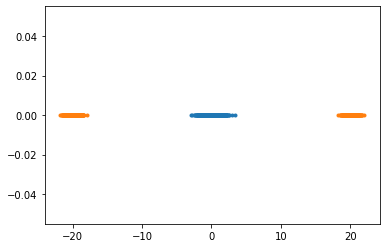

In [6]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 900
n_2 = int(n * 1.0 / 3)
n_2 = int(n * 1.0 / 2.0)


X1 = npr.randn(n).reshape(-1,1) - 0
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 20
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) -20
# X23 =  0.6 * npr.randn(n_2).reshape(-1,1) + 20

X2 = np.concatenate((X21, X22), axis=0)
X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [ ]:


torch.cuda.manual_seed_all(10)
torch.manual_seed(10)

c = cIPFP(
    X1, X2,  number_time_steps=100, batch_size=900 ,
    step_size=1e-2, weights=[20, 20, 20], rng = None,
    optimizer=torch.optim.Adam, lrs = 0.09, weight_decay=0
)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


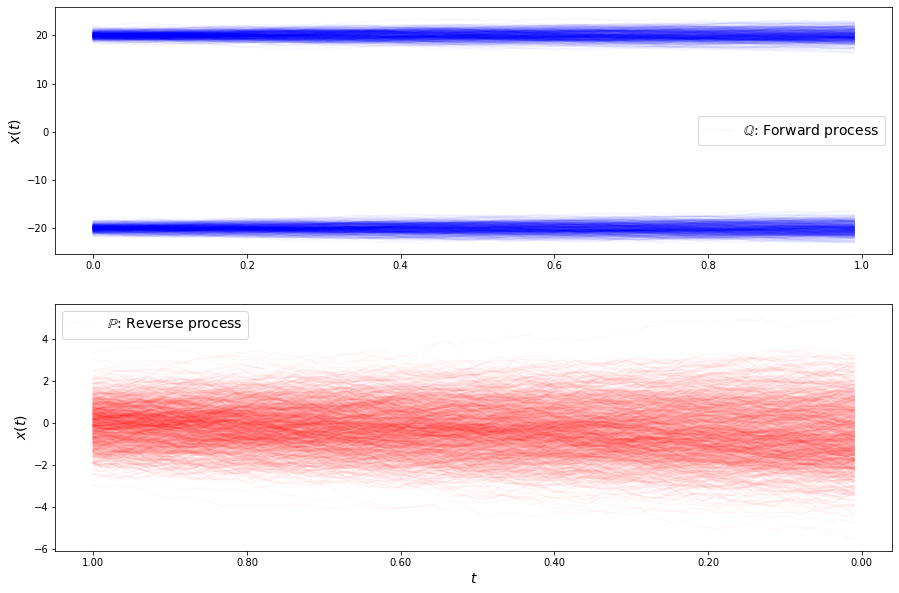

loss b 1194.8435607001934
loss b 902.2198499228653
loss b 730.4079216529154
loss b 508.07959344345056
loss b 498.3210883955353
loss b 472.63370822147823
loss b 413.9929280605973
loss b 365.2578748792543
loss b 344.5673917203864
loss b 263.54523218755116
loss b 295.2906824534257
loss b 264.72170531652284
loss b 246.95795792432045
loss b 220.15737248726683
loss b 222.83673747298633
loss b 233.75524106550148
loss b 211.82340203457824
loss b 180.73269997812486
loss b 204.52270855316783
loss b 194.69387590230974
loss b 180.86577230253926
loss b 183.12556298510052
loss b 174.77719683003417
loss b 154.25257788313934
loss b 165.43216998494992
loss b 161.38629032884697
loss b 149.80102901511307
loss b 171.32974073919385
loss b 156.38754844785163
loss b 161.76661992348167
loss f 123.08461972099221
loss f 102.53388599432992
loss f 101.34008090644399
loss f 89.39152176536246
loss f 78.38490293597954
loss f 80.32856270699504
loss f 80.44628389635889
loss f 75.60696283871461
loss f 72.01024624902311

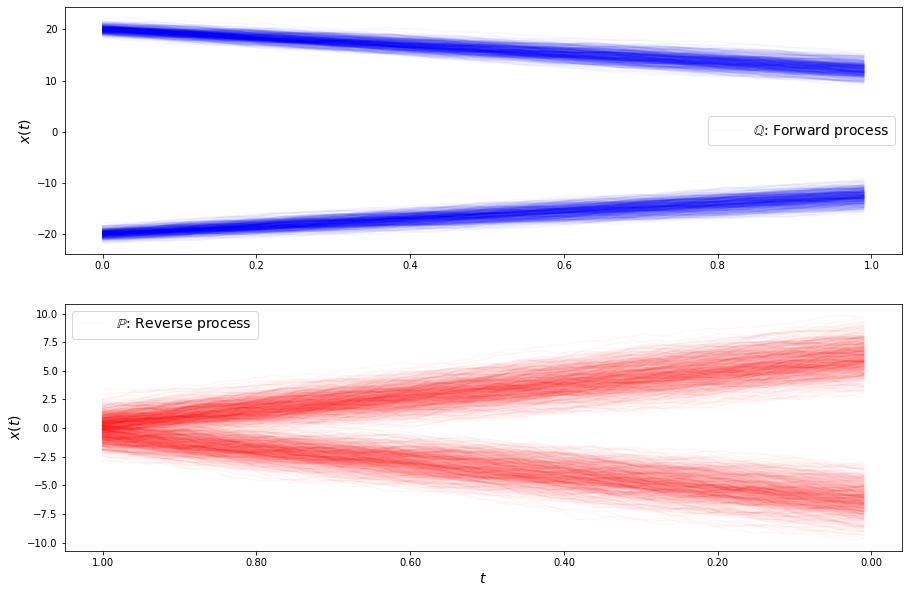

loss b 135.8536895941223
loss b 134.10946497653862
loss b 117.08127129485332
loss b 143.36202221361523
loss b 123.8779161728589
loss b 129.93959952337127
loss b 126.27321969003142
loss b 121.93561469212149
loss b 129.14857409979751
loss b 114.99987644791028
loss b 115.2304739791139
loss b 110.43646856036064
loss b 113.79356065212549
loss b 110.98195880879894
loss b 110.82564948938415
loss b 103.30287455120158
loss b 106.85360728860064
loss b 99.97461136464321
loss b 98.47662545854895
loss b 97.05326134717907
loss b 92.84641281338712
loss b 90.17468028963044
loss b 95.93595171269828
loss b 82.92573943811387
loss b 83.06922979806126
loss b 86.3999665985695
loss b 83.39312483631804
loss b 83.67529547104314
loss b 90.92508058795764
loss b 88.57708119517069
loss f 57.81207519022377
loss f 49.07368934613471
loss f 55.37667826165651
loss f 49.52620100011508
loss f 49.786598398584076
loss f 51.20087551914507
loss f 50.39926537592829
loss f 49.27335833447626
loss f 49.59469964940384
loss f 51.3

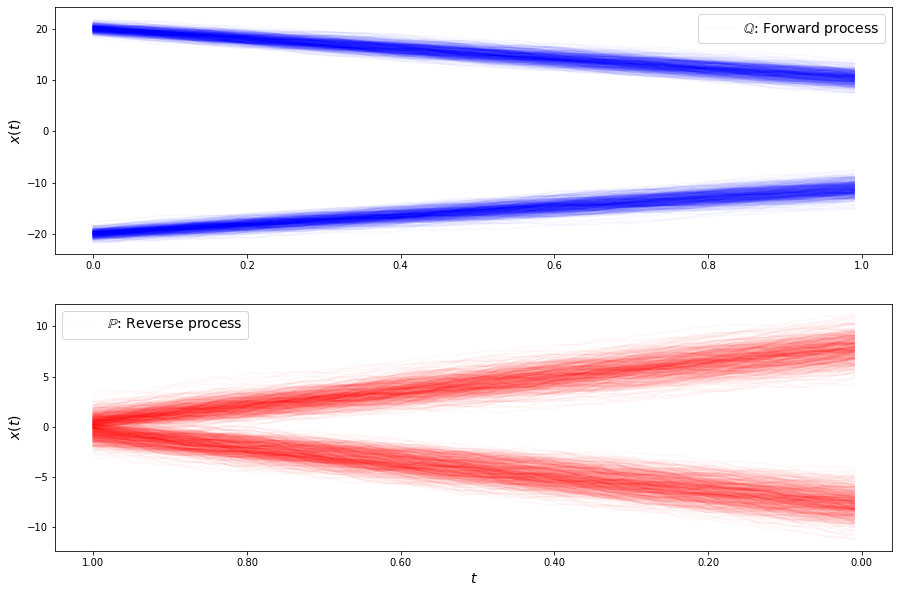

loss b 76.44571381339965
loss b 76.08196356258848
loss b 76.09179993439898
loss b 75.92322250154638
loss b 75.87517845021276
loss b 76.4868344274062
loss b 75.98313058347674
loss b 75.78373372914126
loss b 75.74519337515687
loss b 76.3761199222865
loss b 75.86947420477883
loss b 76.17083762038773
loss b 75.84278043440577
loss b 75.73865882565447
loss b 75.77516343790232
loss b 76.16029101126824
loss b 76.16867763118323
loss b 75.78621526753047
loss b 75.86422537262247
loss b 75.73906529784412
loss b 75.86583692655586
loss b 75.82979343680027
loss b 76.19478374607006
loss b 75.95605015678018
loss b 76.45047866700456
loss b 76.07524026619711
loss b 76.03238136160418
loss b 76.10797821665986
loss b 76.23304048186569
loss b 76.49223032072555
loss f 487.8431230998715
loss f 478.4112641329947
loss f 480.5457751853204
loss f 466.03883901566286
loss f 460.4898577810012
loss f 464.47976168475367
loss f 455.87310366836766
loss f 446.5505176221913
loss f 445.63498424784046
loss f 441.301217497479

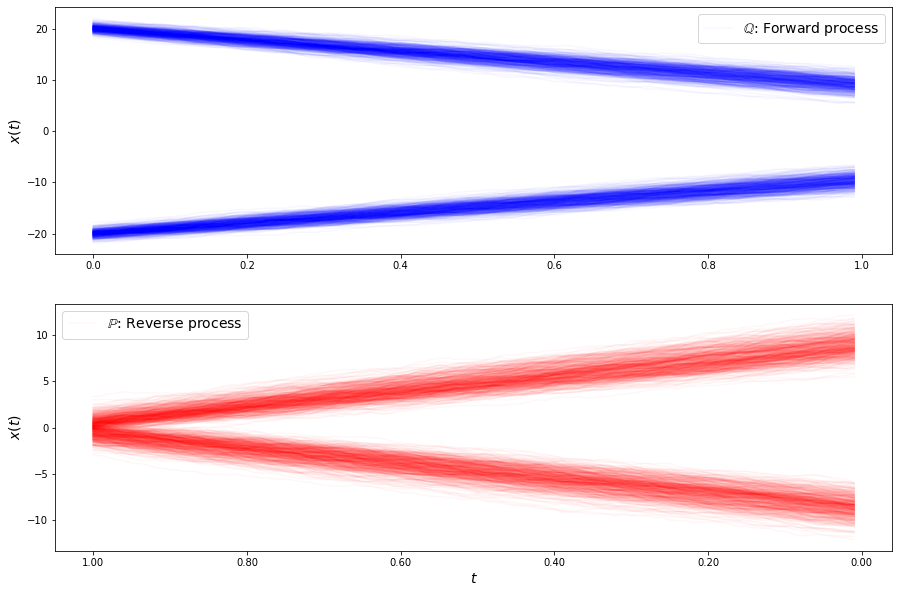

loss b 46.83439784034942
loss b 46.01026127825982
loss b 45.977472427380775
loss b 45.8318013376676
loss b 45.46567193158892
loss b 44.9684537781936
loss b 45.1698073564219
loss b 44.534950352036425
loss b 44.382421462735934
loss b 44.60902053605529
loss b 44.10721005083888
loss b 44.312893149792686
loss b 43.39353987226888
loss b 43.56002285668547
loss b 43.61101471154762
loss b 43.062624135412115
loss b 42.900794891570065
loss b 42.609905592214645
loss b 42.168060580261276
loss b 42.150540858861675
loss b 41.639081467006534
loss b 41.99789472412724
loss b 42.006992949680786
loss b 41.834263651912245
loss b 41.327821447836264
loss b 41.36646001588098
loss b 40.77827619396614
loss b 40.63878161555836
loss b 41.04120689425889
loss b 40.371420842407346
loss f 332.68175435103177
loss f 328.99417861853055
loss f 325.01751501877595
loss f 319.48822524017544
loss f 313.30880448060606
loss f 309.60194137537883
loss f 306.4737627835022
loss f 305.1034188259027
loss f 297.90867507557743
loss f 

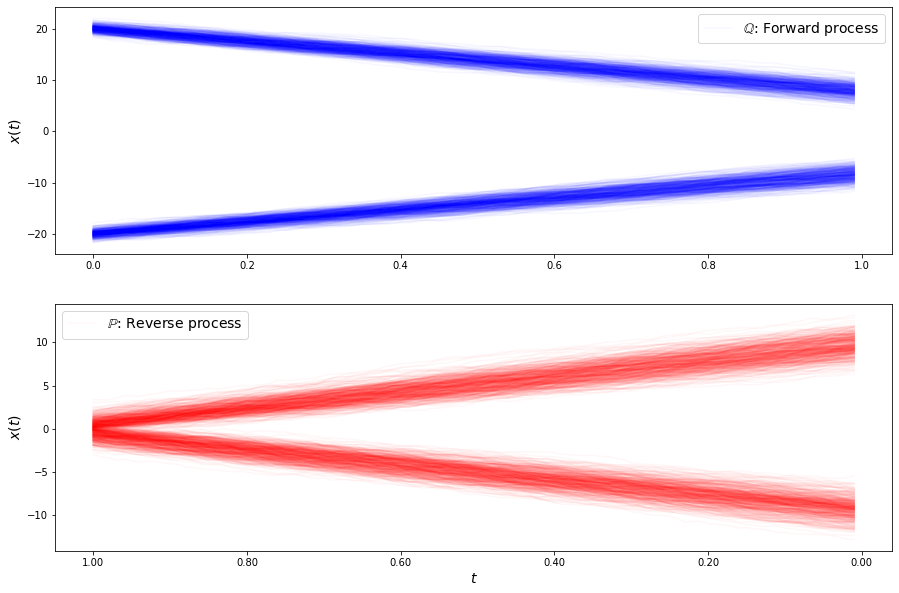

loss b 43.39763321246559
loss b 43.07687325921915
loss b 42.61306375095098
loss b 42.40548361945192
loss b 42.08785248603486
loss b 42.230380946725006
loss b 41.67799435437204
loss b 41.65263399649683
loss b 41.68962736993161
loss b 41.33411579201372
loss b 41.2324359202152
loss b 40.911708724696645
loss b 40.89162745656763
loss b 40.72637210967513
loss b 40.27671324864901
loss b 40.01930179764976
loss b 39.794970058651664
loss b 40.37674967389472
loss b 39.76838716507962
loss b 39.529971994559
loss b 39.41921672806759
loss b 39.32058604061206
loss b 39.363858947996995
loss b 39.07472939029272
loss b 39.08320229403029
loss b 38.535772657243065
loss b 38.253733028606014
loss b 37.58419122514052
loss b 38.07452932198937
loss b 38.510898676603674
loss f 229.11645776567755
loss f 226.0871150252883
loss f 224.07353758129108
loss f 222.9807710794254
loss f 223.80242875151836
loss f 220.69478718839028
loss f 216.44595170507986
loss f 220.1634227850051
loss f 217.0498189879296
loss f 213.76995

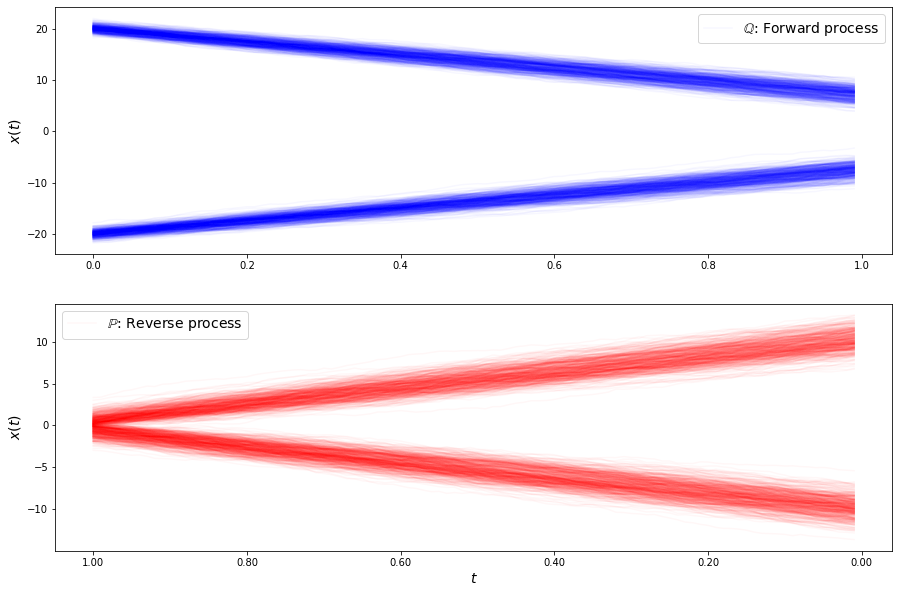

loss b 40.261661262744
loss b 39.697491685329446
loss b 39.7159791602811
loss b 39.523356927180686
loss b 39.43392792784381
loss b 39.534407446251656
loss b 38.819832086808645
loss b 38.86549849922723
loss b 38.6850870726458
loss b 38.52396321152183
loss b 38.44080407668056
loss b 38.27516578136921
loss b 38.217325800580355
loss b 38.13379251133633
loss b 37.55694590366842
loss b 37.71486933430489
loss b 37.398535071797404
loss b 37.42700369367034
loss b 37.13873443179901
loss b 37.109506291299574
loss b 36.58368701509152
loss b 36.77527728906229
loss b 36.88531016161587
loss b 36.287560311169514
loss b 36.1396878134667
loss b 36.11679628296132
loss b 35.63282834952313
loss b 35.80659794252183
loss b 35.85126882576235
loss b 35.460449017042826
loss f 171.55971231688005
loss f 163.60613470116905
loss f 165.6978564318953
loss f 165.51292170396636
loss f 162.38190334377256
loss f 161.5317848582409
loss f 161.77974727615418
loss f 159.04169662509028
loss f 160.18510312069415
loss f 152.611

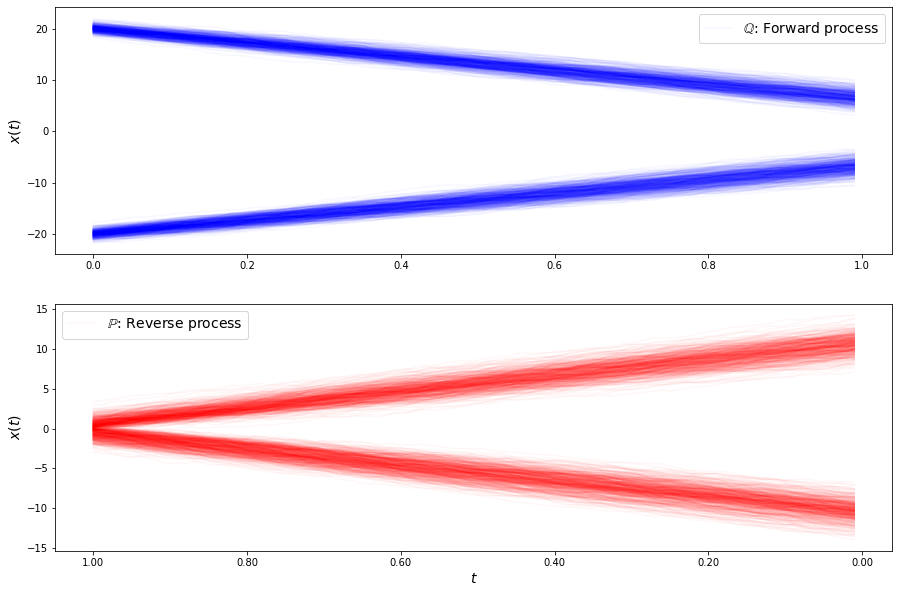

loss b 37.698028866952335
loss b 37.50030744305595
loss b 37.62341166551207
loss b 37.112685691324515
loss b 37.076065499325445
loss b 37.07328115413298
loss b 36.53612602070679
loss b 36.562511199347846
loss b 36.48029550314089
loss b 36.29053639433384
loss b 36.01077606805991
loss b 36.27594085919002
loss b 35.67684229336502
loss b 35.59994179435681
loss b 35.620873405665925
loss b 35.87034159056341
loss b 35.53393351208405
loss b 34.87737001639088
loss b 34.93129202283437
loss b 34.95872559375378
loss b 34.97238055453017
loss b 34.55348310439305
loss b 34.720699984153214
loss b 34.00658997659356
loss b 33.9740034388751
loss b 34.071737758907865
loss b 34.17128195231876
loss b 33.87373510760669
loss b 33.74257459869295
loss b 33.42334628134832
loss f 127.12652876382992
loss f 127.1153360512218
loss f 128.5845624089253
loss f 124.96567779863912
loss f 125.4383441332844
loss f 124.94334182954623
loss f 123.64223882622629
loss f 121.41936397432112
loss f 124.19075458710347
loss f 119.88

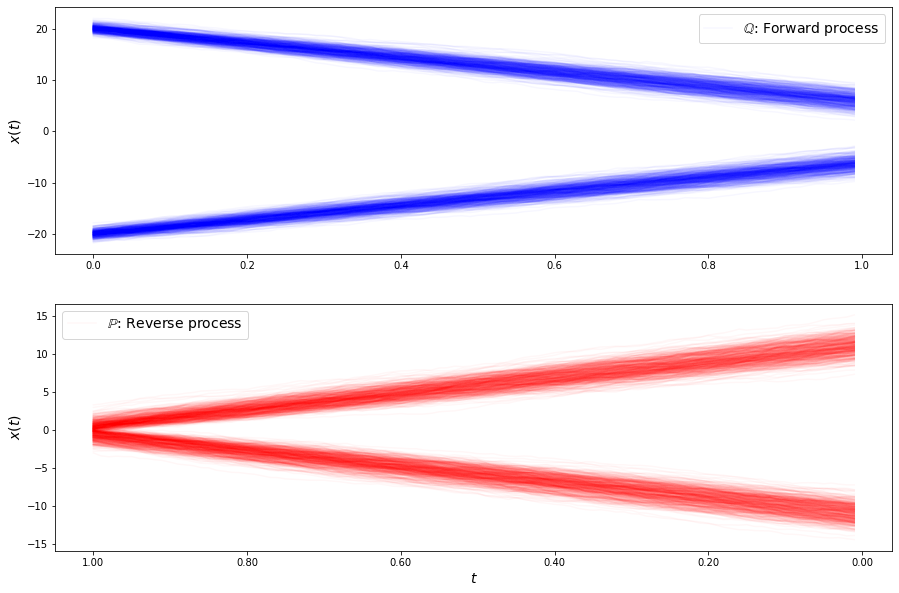

loss b 35.54588410240327
loss b 35.07191749480186
loss b 34.817339484206286
loss b 35.33043091704904
loss b 34.69932197260313
loss b 34.729973830890984
loss b 34.25612284660413
loss b 34.16063446906879
loss b 34.07014302697229
loss b 34.24967178794581
loss b 33.92234153789997
loss b 33.774546970465686
loss b 33.70074892965916
loss b 33.95231799073304
loss b 33.60341282268425
loss b 33.29255617285791
loss b 33.01242421029937
loss b 33.18055320003727
loss b 32.814511759124365
loss b 33.01027105053596
loss b 32.43793837344769
loss b 33.04639029754542
loss b 32.298799120591454
loss b 32.43094653798874
loss b 32.358814510533925
loss b 31.94419663429817
loss b 32.07662353666318
loss b 31.721506925705004
loss b 31.745119513065685
loss b 31.808904729866182
loss f 102.48894900837092
loss f 99.73622260682133
loss f 101.16040737851776
loss f 96.76919494354325
loss f 99.89878507506117
loss f 98.2555530661007
loss f 96.00430949475904
loss f 97.0174203590454
loss f 92.1563227120736
loss f 93.8911649

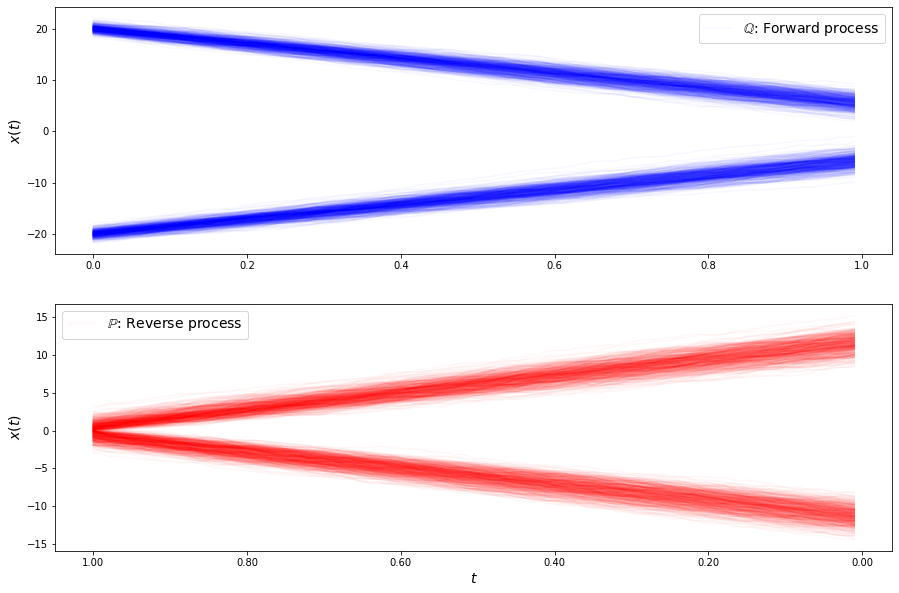

loss b 32.77041134378638
loss b 32.438064892945214
loss b 32.633051201726225
loss b 32.031130724513
loss b 31.979112877449285
loss b 32.062659287147426
loss b 31.977527756019583
loss b 31.65373041275435
loss b 31.322898335197063
loss b 31.647011174826723
loss b 31.462572676890446
loss b 31.11198073320182
loss b 30.86180955623914
loss b 31.134741352292284
loss b 31.022701972105242
loss b 30.693564401692477
loss b 30.506862668259455
loss b 30.586086047311312
loss b 30.67945016066934
loss b 30.29188838713508
loss b 30.053677957986846
loss b 30.28270750733477
loss b 29.76002380013135
loss b 29.71203024557527
loss b 29.919391391302785
loss b 29.680713551287862
loss b 29.80091417281861
loss b 29.318767093475202
loss b 29.373252600876643
loss b 28.919833023137084
loss f 80.38579638451971
loss f 80.75305141225296
loss f 78.34452541414477
loss f 78.7661358478967
loss f 73.36753723063073
loss f 76.08220116956942
loss f 76.77441277272446
loss f 76.51805899455792
loss f 77.43084201577639
loss f 74

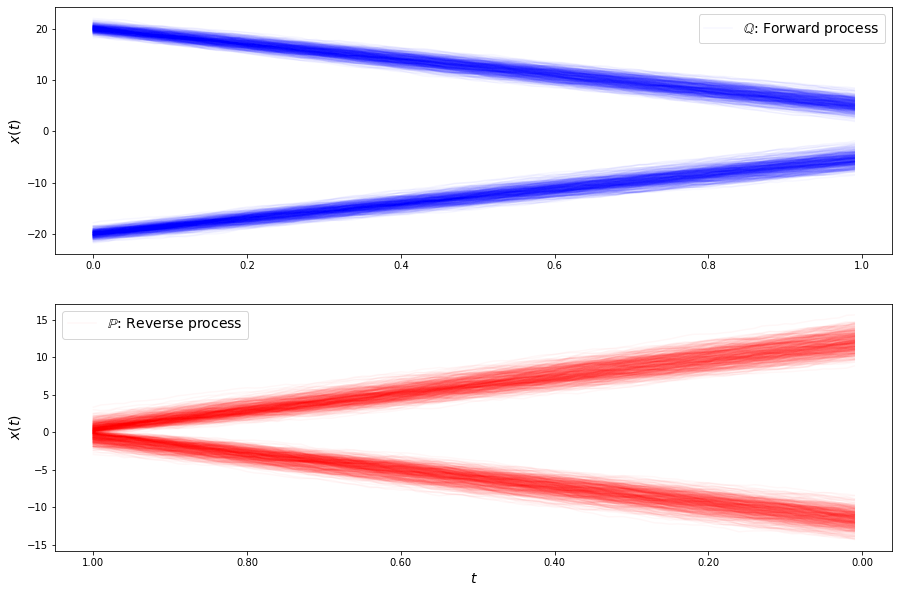

loss b 30.901196335483206
loss b 30.48283320392375
loss b 30.172629300751822
loss b 30.567351115637422
loss b 30.282709861163283
loss b 30.01439535185324
loss b 30.263097561525758
loss b 30.182748879203327
loss b 29.781007966183555
loss b 29.69891715703523
loss b 29.183034785994693
loss b 29.411931152994633
loss b 29.291146604141193
loss b 29.302194333927357
loss b 29.36940195714845
loss b 28.944649442321257
loss b 29.106937140663128
loss b 28.635423292324642
loss b 28.754516280020272
loss b 28.477516313183052
loss b 28.579559059404033
loss b 28.450156817204565
loss b 28.701526136522265
loss b 28.09964753699752
loss b 27.925950829593074
loss b 28.18236974324529
loss b 27.945117487361674
loss b 27.932070389660247
loss b 27.580676878556396
loss b 27.897093591014027
loss f 62.56669123818389
loss f 66.10795080917254
loss f 66.4361289595434
loss f 61.654129725141736
loss f 66.29960249833485
loss f 61.400178456289645
loss f 61.84752987531747
loss f 63.53142316598267
loss f 62.22847044633996


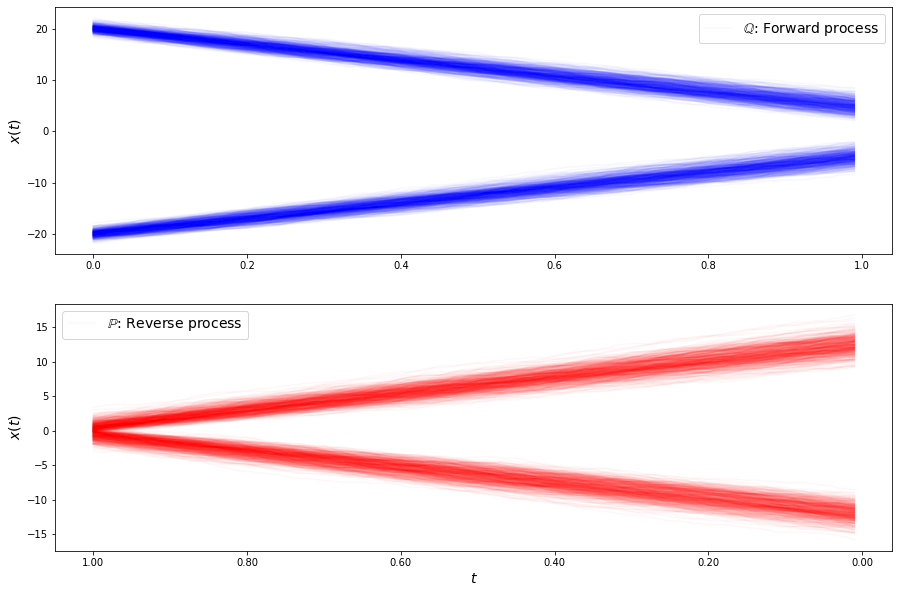

loss b 28.960078892097737
loss b 28.91810017746134
loss b 28.695661581091723
loss b 29.108079112235135
loss b 28.494659735303912
loss b 28.523465656919218
loss b 28.707517378504043
loss b 28.277750703105
loss b 28.3030573764709
loss b 28.418551110680657
loss b 28.242488482144953
loss b 28.16675694028062
loss b 27.744124689606387
loss b 27.636801723129867
loss b 27.947403831590734
loss b 27.673456930334524
loss b 27.967815343035596
loss b 27.45408197708467
loss b 27.65072616458189
loss b 27.501734261518717
loss b 27.507674697848554
loss b 27.136634682372765
loss b 27.29894640848314
loss b 27.3217697466461
loss b 27.395872755500662
loss b 26.79305966057638
loss b 26.711378025241938
loss b 26.808487702905385
loss b 26.883259782608786
loss b 26.701276309456183
loss f 56.04270170102293
loss f 55.148416209678345
loss f 53.62674718297293
loss f 53.24173440621805
loss f 52.64718578341945
loss f 53.649399142889166
loss f 52.31448711426705
loss f 51.30333525184605
loss f 51.639898219874
loss f 5

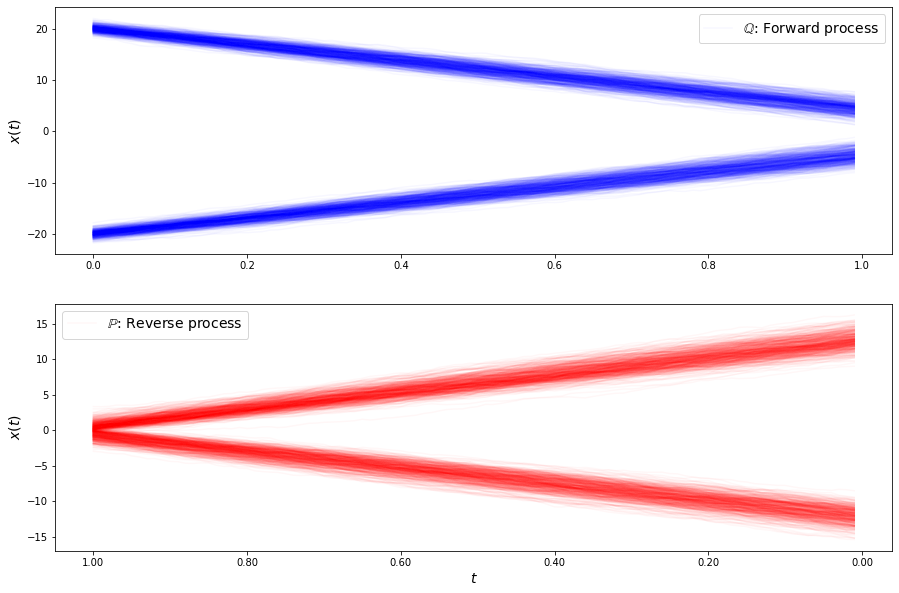

loss b 27.807934248668545
loss b 27.581443491967903
loss b 27.30351565404337
loss b 27.27771046289931
loss b 27.44782992764882
loss b 27.252937411108842
loss b 27.128653967717284
loss b 26.917656435915394
loss b 26.888142030310586
loss b 26.71953159862962
loss b 26.708834745331597
loss b 26.8115419456981
loss b 26.46057286244609
loss b 26.747582301215225
loss b 26.54805631405058
loss b 26.2889188638851
loss b 26.802011945746493
loss b 26.388615479938906
loss b 26.228403973819002
loss b 26.025735459416026
loss b 26.224789527907415
loss b 25.796268358902356
loss b 26.0167063152492
loss b 26.121689860493056
loss b 25.79960981191977
loss b 25.696570852212375
loss b 25.412611201766182
loss b 25.74286578043937
loss b 25.306845199989507
loss b 25.0732000501479
loss f 45.51681660237452
loss f 43.50964069404218
loss f 46.377830039522195
loss f 44.59951915974361
loss f 44.6271053842968
loss f 44.034069184448526
loss f 44.82867727660571
loss f 43.65017232559449
loss f 43.22162463885731
loss f 43.

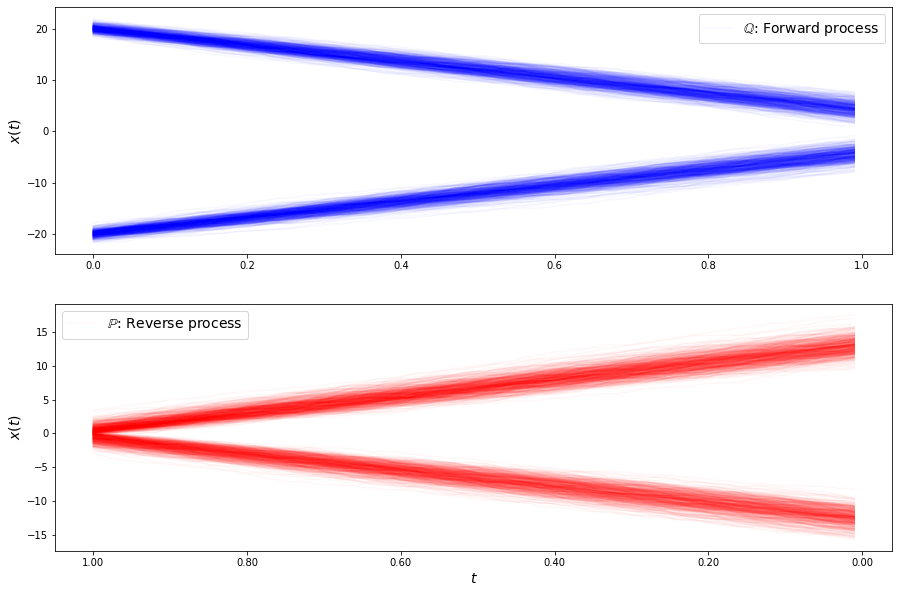

loss b 25.761774099801638
loss b 26.138731422023074
loss b 25.993851867606065
loss b 25.988119321638184
loss b 25.663141027864857
loss b 25.416247503995706
loss b 25.559669641343472
loss b 25.709896927648355
loss b 25.466422649122155
loss b 25.602265656264017
loss b 25.577517431438654
loss b 25.263265621891716
loss b 25.060779378438
loss b 24.997854430983317
loss b 25.098628804500446
loss b 24.929265448794638
loss b 24.852191678114767
loss b 24.63927838449262
loss b 24.92117609981275
loss b 24.7991120968929
loss b 24.35563868730474
loss b 24.300886770827898
loss b 24.395328721350456
loss b 24.53564243412907
loss b 24.21792062353101
loss b 24.346343330644764
loss b 24.109106239892697
loss b 24.280989665477442
loss b 24.525911233235597
loss b 24.118482521933913
loss f 39.79219911381078
loss f 39.63441605417561
loss f 38.501743648350555
loss f 39.21951927151952
loss f 38.6154236960597
loss f 38.901902813658516
loss f 37.60306916585145
loss f 37.48224530343032
loss f 38.801085624753554
los

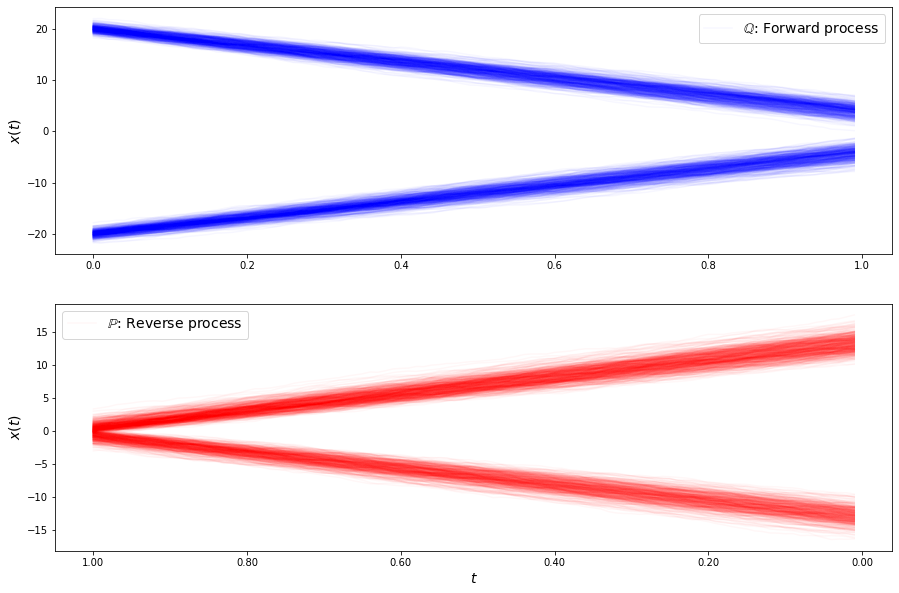

loss b 24.708037449362884
loss b 24.601564068341144
loss b 24.587817726227435
loss b 24.293915393990744
loss b 24.593640328192063
loss b 24.5268491346782
loss b 24.09660716754835
loss b 24.38763861180437
loss b 24.085569255608743
loss b 24.048198114212763
loss b 24.16310330563526
loss b 23.590623557688208
loss b 23.77599282161326
loss b 23.906728246704223
loss b 23.672584678054836
loss b 23.642389525593725
loss b 23.522205943878706
loss b 23.583747275543622
loss b 23.81932524408789
loss b 23.511843981256067
loss b 23.19555990990353
loss b 23.42856663495582
loss b 23.328196357655326
loss b 23.174424099424172
loss b 23.220701233362785
loss b 23.077714212317755
loss b 22.782208476386757
loss b 22.774096715211382
loss b 22.852736510737174
loss b 22.934081748142543
loss f 33.40477178407453
loss f 35.61153262709683
loss f 34.52778129958009
loss f 33.89451733956821
loss f 34.07166893036558
loss f 34.34478945669186
loss f 33.115023544320536
loss f 31.720093915519396
loss f 32.09454508515037
lo

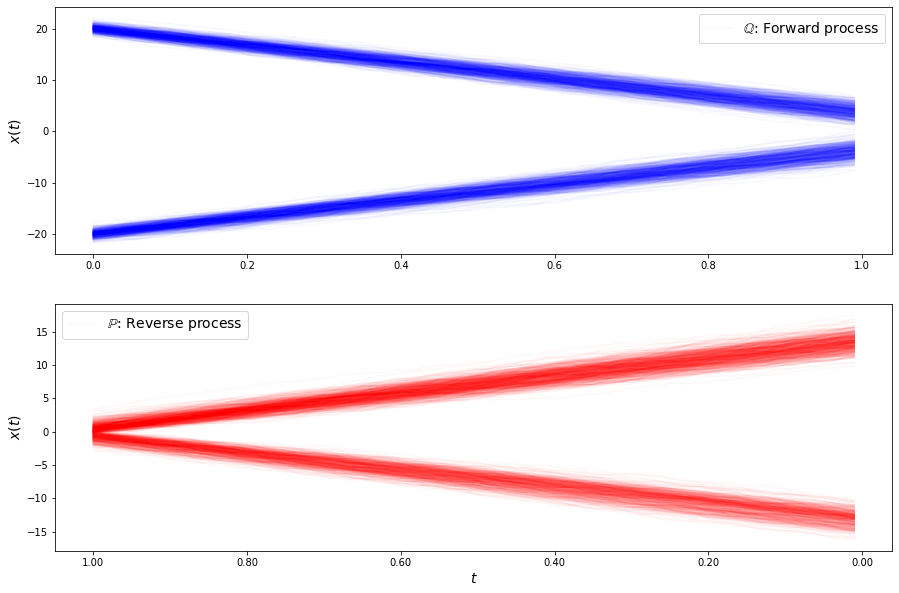

loss b 23.970691840686847
loss b 23.726588064149915
loss b 23.785397156394428
loss b 23.46857353475071
loss b 23.83713159185853
loss b 23.195003260876625
loss b 23.3799130753914
loss b 23.224795437466476
loss b 23.35226322321753
loss b 23.27569927585601
loss b 23.17643578583841
loss b 23.20060402300205
loss b 23.11410786869762
loss b 22.861794583791184
loss b 22.722391622582688
loss b 22.572190785609653
loss b 22.782940502100487
loss b 22.545573929914756
loss b 22.733450027281236
loss b 22.5211233896177
loss b 22.531057095580888
loss b 22.437429962837978
loss b 22.58759785975294
loss b 22.440775966398697
loss b 22.38035813576125
loss b 22.380845358043036
loss b 22.20751215589915
loss b 22.131812607440345
loss b 22.211067219388607
loss b 22.165463645485545
loss f 29.782377303158093
loss f 30.241254424575512
loss f 28.668381835590615
loss f 29.764770400599858
loss f 29.25730632590134
loss f 29.980761530326145
loss f 30.016453106850825
loss f 29.524059886912568
loss f 29.33257116221025
lo

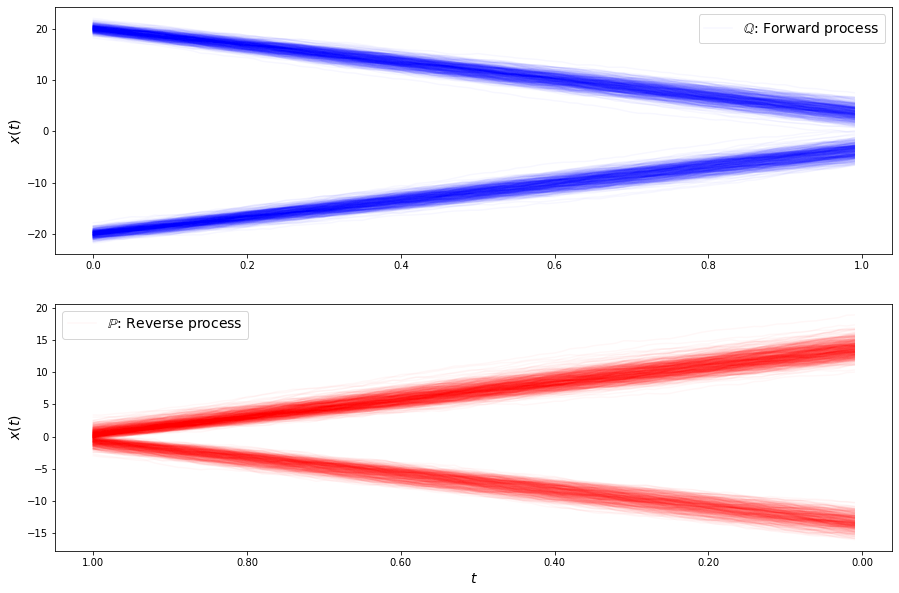

loss b 22.979360520840004
loss b 22.634336720100446
loss b 22.745322260602997
loss b 22.67496375602517
loss b 22.43299019360563
loss b 22.742290881677185
loss b 22.689622199016057
loss b 22.550285406705996
loss b 22.421130286028667
loss b 22.288159530550995
loss b 22.187277759860713
loss b 22.095194517724234
loss b 21.97192184648089
loss b 22.294596691082837
loss b 22.180685857882068
loss b 21.908723035980334
loss b 21.98909907349915
loss b 21.906222594675228
loss b 22.00708271441868
loss b 21.98264030171094
loss b 21.43988040894621
loss b 21.895297211090554
loss b 21.84067133785021
loss b 21.68738710541017
loss b 21.522252659305472
loss b 21.444462394740608
loss b 21.411490562629055
loss b 21.479221151371366
loss b 21.252221207071386
loss b 21.440656987773185
loss f 25.946346502760733
loss f 27.198400680727367
loss f 26.607440071372206
loss f 25.66003372285402
loss f 27.3956113921921
loss f 27.26704977565166
loss f 26.865256142572207
loss f 24.939115660243708
loss f 25.48647658950616


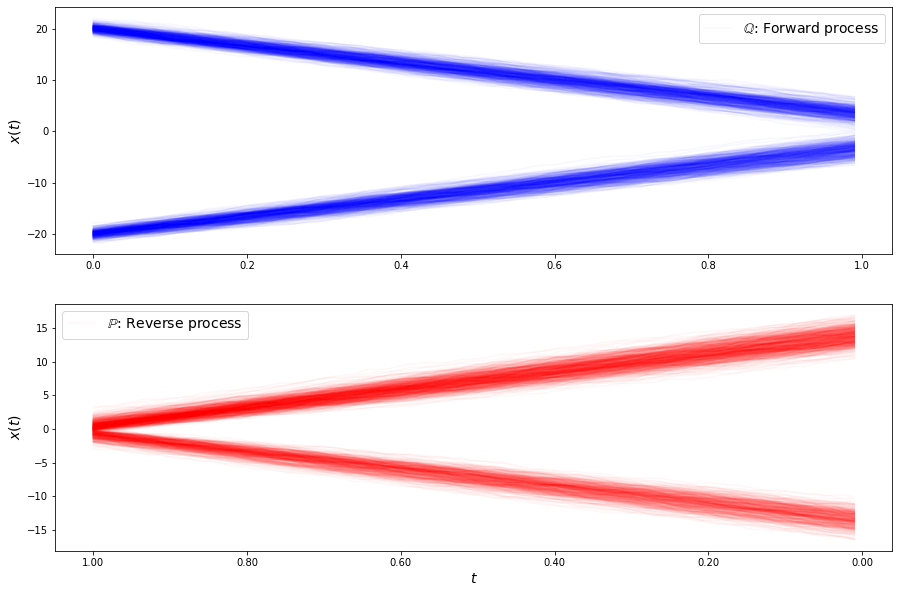

loss b 21.959807230666225
loss b 21.65156463536529
loss b 21.783342844716664
loss b 21.974332935676337
loss b 21.713620185364018
loss b 21.885389114949017
loss b 21.951658205505638
loss b 21.77750140240955
loss b 21.39114617401668
loss b 21.580871141598728
loss b 21.726179940798094
loss b 21.48795997317562
loss b 21.408242664540307
loss b 21.503000524508053
loss b 21.292436200160964
loss b 21.02459623843914
loss b 21.180582458887347
loss b 20.99687535224162
loss b 20.95623158123031
loss b 20.916262798781737
loss b 20.86024886900435
loss b 20.885988286660663
loss b 20.643677204368473
loss b 20.869125623033778
loss b 20.836359109445084
loss b 20.446944188680167
loss b 20.789398292710157
loss b 20.57660207850925
loss b 20.41497023282432
loss b 20.57499690394901
loss f 23.80781687519147
loss f 24.973326861553407
loss f 23.17404237858901
loss f 24.343450836463997
loss f 23.033030644277677
loss f 23.85525535781237
loss f 23.155760324200454
loss f 23.002394109478903
loss f 23.269911333992372


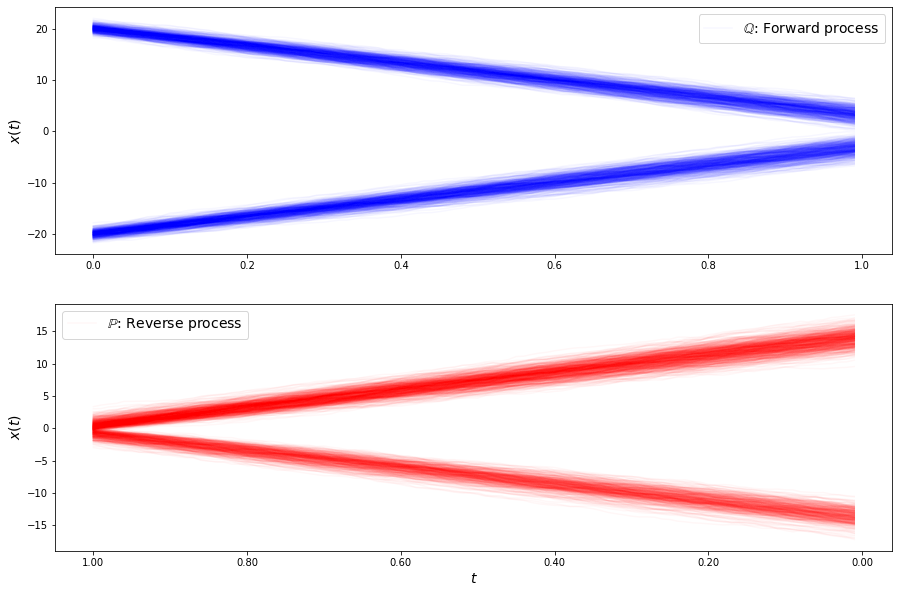

loss b 20.843377291605435
loss b 21.012608905906145
loss b 20.928685498986436
loss b 21.030694432272288
loss b 20.57669170909448
loss b 20.818997485686932
loss b 20.67282723427805
loss b 20.651497887367203
loss b 20.44020679706124
loss b 20.464231068577362
loss b 20.585037873348934
loss b 20.704636444121284
loss b 20.417397396339407
loss b 20.40052752930615
loss b 20.6077297461498
loss b 20.53810173746081
loss b 20.519387786798752
loss b 20.524344117392218
loss b 20.304968275917705
loss b 20.17451996532269
loss b 20.042778394551718
loss b 20.22227981180463
loss b 20.04967395022546
loss b 20.03262133173779
loss b 19.911269970232855
loss b 19.793647734298517
loss b 20.0872565019845
loss b 19.93559577431386
loss b 19.79439184478293
loss b 19.79932210385139
loss f 22.247751413920046
loss f 22.233762365094748
loss f 21.57855514842365
loss f 22.172998583799977
loss f 21.845375308997774
loss f 22.294540299577214
loss f 21.87289259582437
loss f 22.499107168917256
loss f 21.01313343692241
loss 

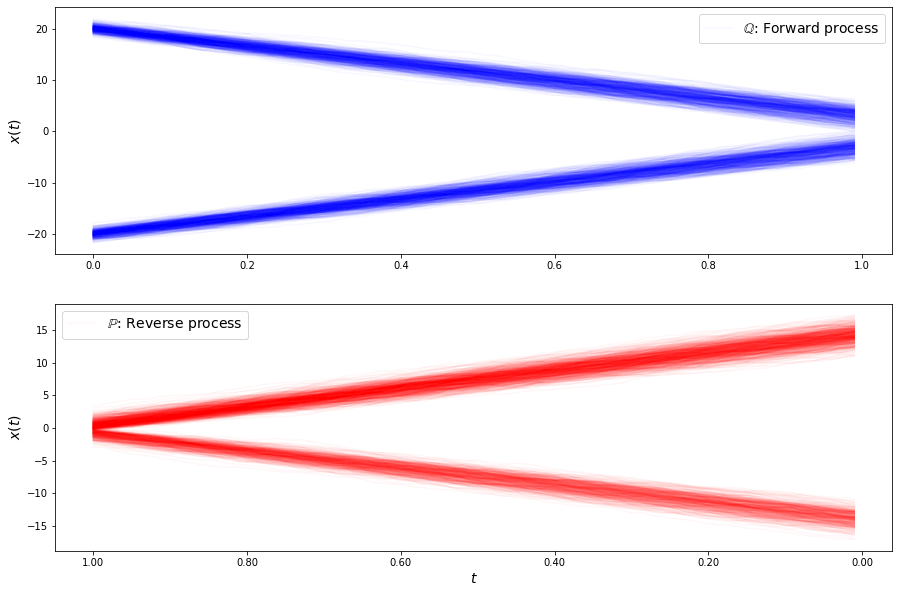

loss b 20.105615338379923
loss b 20.030317540209662
loss b 20.20974048157779
loss b 20.00370526011485
loss b 19.9388382462989
loss b 19.8756764528917
loss b 19.81937469709514
loss b 19.833066143747264
loss b 19.79575331420357
loss b 19.823806786609257
loss b 19.67637478976252
loss b 19.39091204049838
loss b 19.76410716149056
loss b 19.52495406368187
loss b 19.552112272215734
loss b 19.46840647892107
loss b 19.46854340601572
loss b 19.429628202672685
loss b 19.492350111650186
loss b 19.393618302483496
loss b 19.414761610936274
loss b 19.307018633401455
loss b 19.357945625293283
loss b 19.290012237446906
loss b 19.402151484070522
loss b 19.13139632782282
loss b 19.228626317750024
loss b 19.275830993497248
loss b 18.8437297060455
loss b 18.824048257348295
loss f 19.653243337769844
loss f 19.910690498262984
loss f 20.243404094471153
loss f 21.365671376089594
loss f 19.863521414645486
loss f 19.773298997467137
loss f 19.449505939208986
loss f 20.598176112521692
loss f 20.085932864552223
los

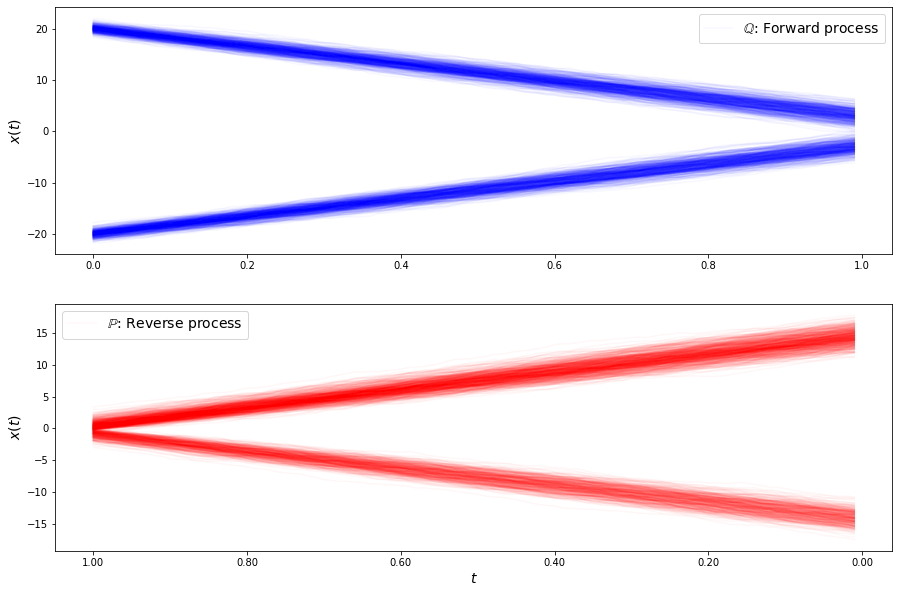

loss b 19.527862225670006
loss b 19.25174493049952
loss b 19.19932278133692
loss b 18.91362708022618
loss b 19.30792386837446
loss b 19.089933189946418
loss b 18.98917675494622
loss b 19.026655415139125
loss b 19.059463032143988
loss b 18.888894538141617
loss b 18.703407843758875
loss b 18.890932862953147
loss b 18.901099374898784
loss b 18.836502099853412
loss b 18.79521564470113
loss b 18.550054785695988
loss b 18.75274270759063
loss b 18.54829134795028
loss b 18.622972741625983
loss b 18.483004533749188
loss b 18.71124502710041
loss b 18.24795497875136
loss b 18.496746374190096
loss b 18.22377600662782
loss b 18.173794076532328
loss b 18.301756948586117
loss b 18.490295585407544
loss b 18.1707241159542
loss b 18.29013123748161
loss b 18.226755653565217
loss f 18.169175266112592
loss f 17.975119371066643
loss f 18.740035549727423
loss f 18.779338514117175
loss f 18.12611884922588
loss f 18.39941658339548
loss f 18.334738868051943
loss f 18.206434183216846
loss f 17.81985548232374
los

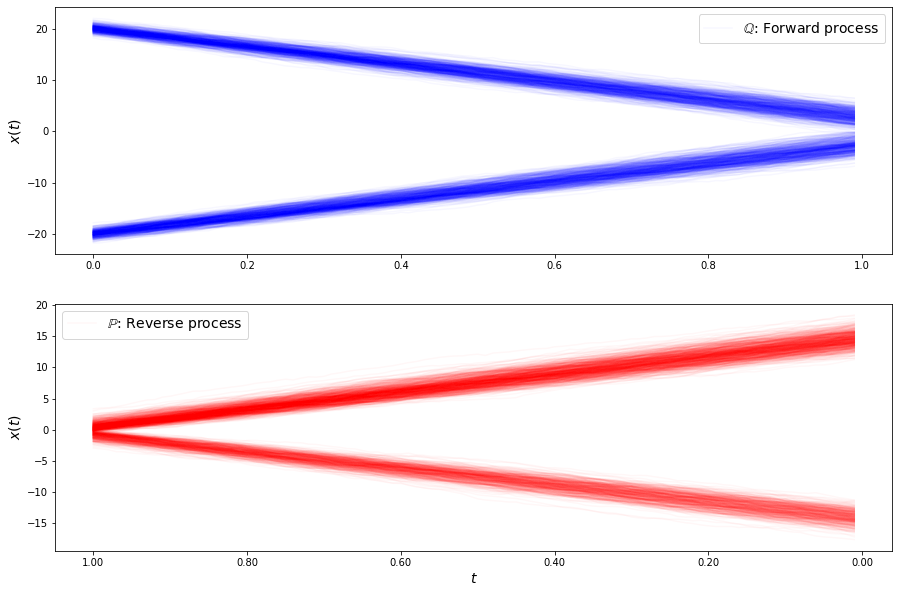

loss b 18.36952527471852
loss b 18.348519864378165
loss b 18.295102886997167
loss b 18.47855688961495
loss b 18.370538735772485
loss b 18.26613760612581
loss b 18.134396804201895
loss b 18.28335716287764
loss b 18.40868114986555
loss b 18.47078277939202
loss b 18.28168575797989
loss b 18.126063829677236
loss b 18.27271178654603
loss b 17.901338210952254
loss b 18.0200856095023
loss b 17.853382112599352
loss b 18.129049146001428
loss b 17.94960620550224
loss b 17.726541040803255
loss b 17.830145696449133
loss b 18.009756739732
loss b 17.790356255747025
loss b 17.747052928792655
loss b 17.822006245802527
loss b 17.574643328108515
loss b 17.799588342526555
loss b 17.711619684477764
loss b 17.442268605828673
loss b 17.560618605891527
loss b 17.34808567382193
loss f 17.125312436608056
loss f 17.94242490907915
loss f 16.906066935560347
loss f 17.165791688536334
loss f 16.817143393021123
loss f 17.76516891736402
loss f 17.063027892666156
loss f 16.364173025011482
loss f 17.925829352946508
los

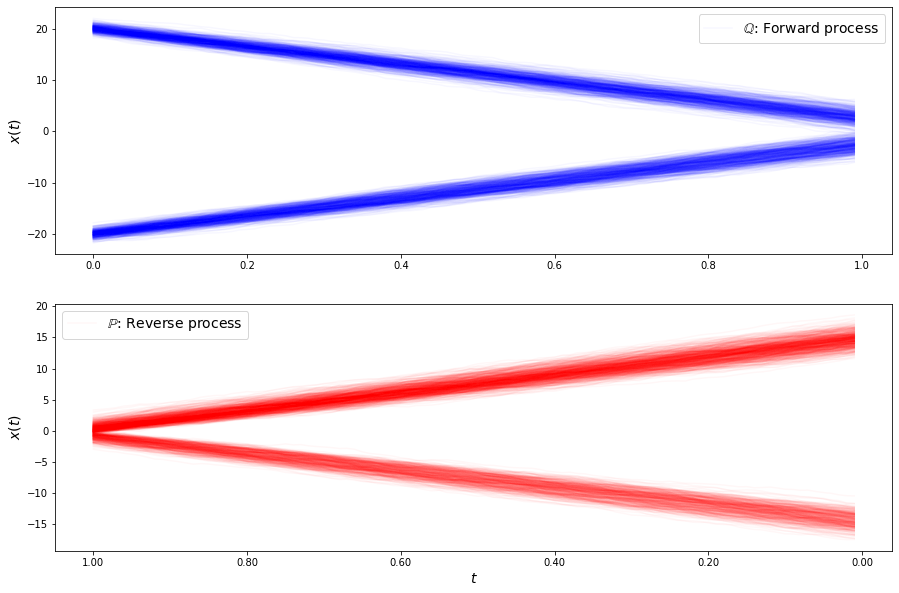

loss b 17.807203246245617
loss b 17.71930586609522
loss b 17.786434322649324
loss b 17.82940309721088
loss b 17.699076787216246
loss b 17.569469120452414
loss b 17.621539013527393
loss b 17.712500721547638
loss b 17.736567591434472
loss b 17.511321387971932
loss b 17.476709886078368
loss b 17.371157349656045
loss b 17.42054694774785
loss b 17.21064329911519
loss b 17.37422514902759
loss b 17.20064676804724
loss b 17.450886969328224
loss b 17.219120006555713
loss b 17.03206403248359
loss b 17.160600937858938
loss b 16.986492956637644
loss b 17.055279439771134
loss b 17.079352361787304
loss b 17.06641135325824
loss b 16.792252492814058
loss b 17.019793699856464
loss b 16.954763942697465
loss b 17.027413682403758
loss b 17.078377251589824
loss b 16.60702224286372
loss f 16.036549724555513
loss f 15.728803511636142
loss f 16.4033992991739
loss f 15.160735315317007
loss f 16.2320217961636
loss f 15.971429514212348
loss f 15.545767469947009
loss f 15.735252489877693
loss f 16.268106314934517

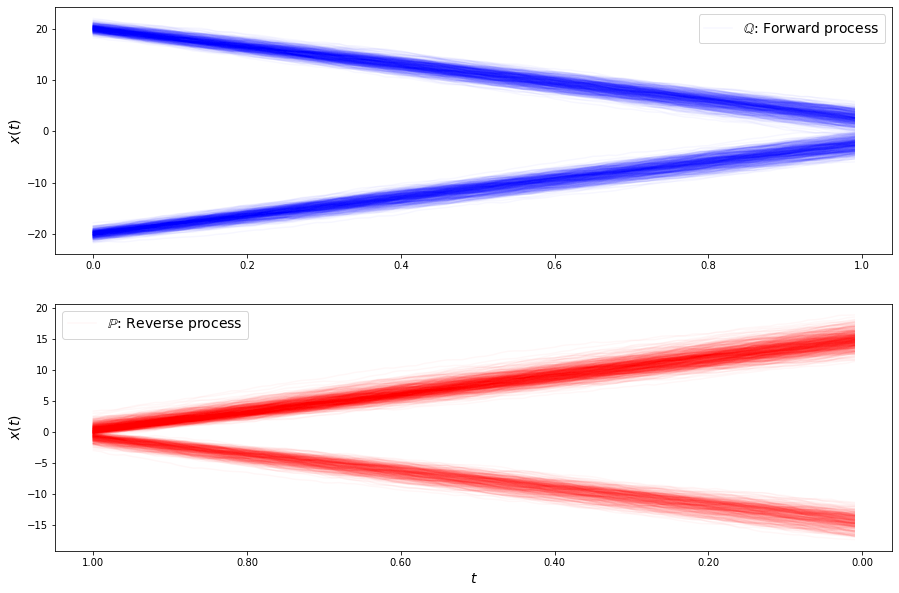

loss b 17.06464658092441
loss b 17.111113117464093
loss b 17.24545638488934
loss b 17.07806342926674
loss b 16.99357961601058
loss b 17.000916587892128
loss b 16.97181983742927
loss b 17.056789326388508
loss b 16.935797271453847
loss b 16.904893287514664
loss b 16.667530389577166
loss b 16.97592673594553
loss b 16.707903675463793
loss b 16.725380340163433
loss b 16.632572300797634
loss b 16.518011579599552
loss b 16.66829962994899
loss b 16.612506607346734
loss b 16.56250381184975
loss b 16.55709759533385
loss b 16.652761501444502
loss b 16.413413514295556
loss b 16.571719770027226
loss b 16.387860857388556
loss b 16.36806154126935
loss b 16.361955745782556
loss b 16.435713754570855
loss b 16.332811528759255
loss b 16.257973239627333
loss b 16.275440885907248
loss f 14.641721916103053
loss f 15.11692924679233
loss f 15.20674789149691
loss f 14.648030892474406
loss f 15.15795859793217
loss f 14.49050997897357
loss f 14.672968887189594
loss f 15.26090318407039
loss f 14.518847616197796
l

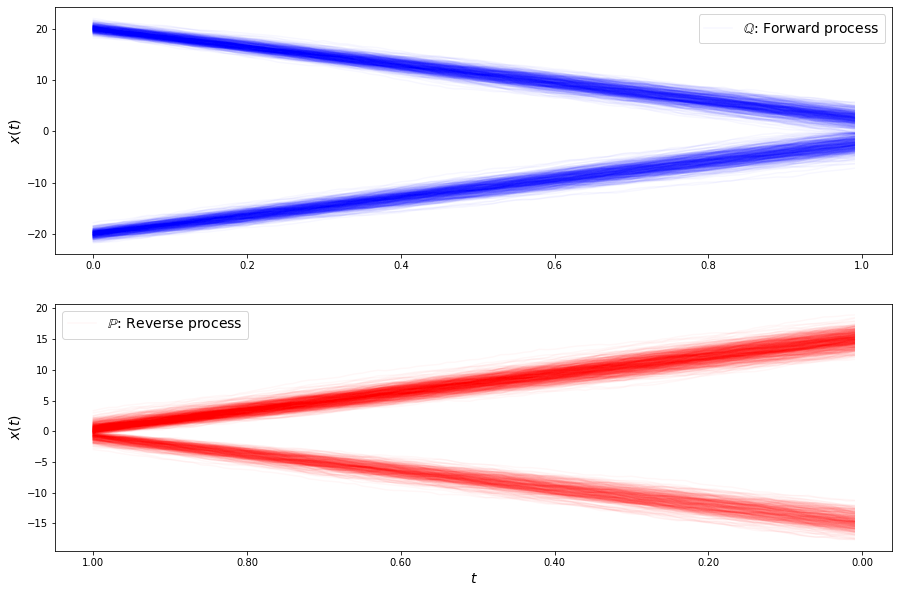

loss b 16.737238775636847
loss b 16.528870822980824
loss b 16.582122507583748
loss b 16.299987160764175
loss b 16.46972830732512
loss b 16.583769596049237
loss b 16.335634285717095
loss b 16.332752423585294
loss b 16.258165814279458
loss b 16.1954428460405
loss b 16.347806729170593
loss b 16.28203475131878
loss b 16.443876169341852
loss b 16.096614115653225
loss b 16.114507952139288
loss b 16.245171148950533
loss b 16.06171294921209
loss b 16.308810762048243
loss b 16.16983731292416
loss b 16.119877819336313
loss b 16.001945325884886
loss b 15.800559293721046
loss b 15.78481519560727
loss b 15.940121103128744
loss b 16.06106357350904
loss b 15.664269082603871
loss b 15.835278395132109
loss b 15.527652187964048
loss b 15.807278544884909
loss b 15.635584501074678
loss f 13.96591152165972
loss f 14.056785377429458
loss f 14.232614765369954
loss f 14.105203746407883
loss f 14.1692509699026
loss f 14.35394017966672
loss f 14.68176219857323
loss f 13.88477521022667
loss f 13.961891071261602


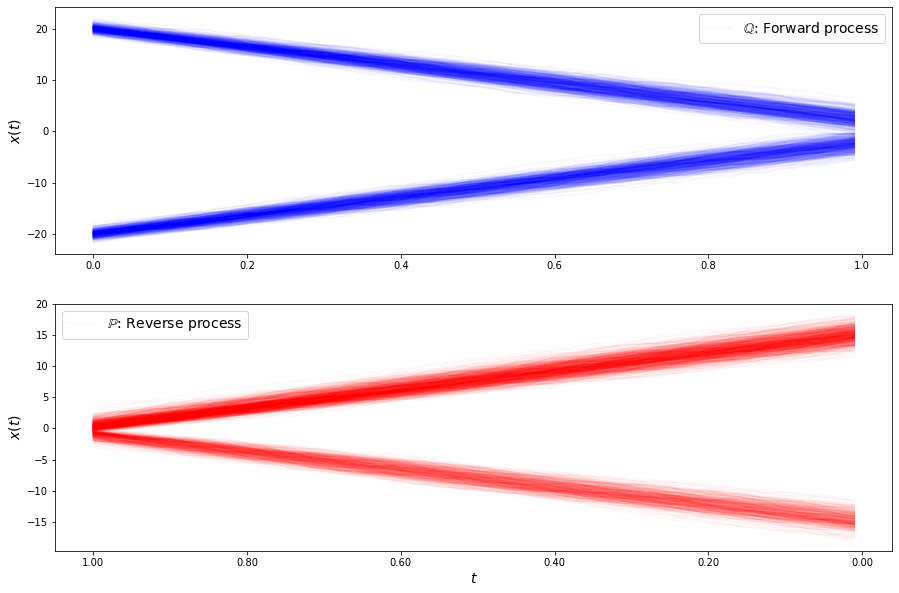

loss b 15.970975173000683
loss b 16.06191487708345
loss b 16.095594811656298
loss b 15.874519109101199
loss b 15.936090139080967
loss b 15.81674266548736
loss b 15.920789855127426
loss b 15.929068704285068
loss b 15.870779007962492
loss b 15.921879253096556
loss b 15.663206877016707
loss b 15.61552974256054
loss b 15.662935995991887
loss b 15.71759961201835
loss b 15.473823268756169
loss b 15.685151186685562
loss b 15.66752065519228
loss b 15.443535965280583
loss b 15.52063587583743
loss b 15.321901399233866
loss b 15.620828882193054
loss b 15.515042312310992
loss b 15.274146114567268
loss b 15.563429595295036
loss b 15.47426112503832
loss b 15.301662448799108
loss b 15.36321928795553
loss b 15.195926265766799
loss b 15.284561230888913
loss b 15.273621736050002
loss f 13.488602030848757
loss f 13.393109010301314
loss f 13.802708055062965
loss f 13.192477138511233
loss f 13.383758841216606
loss f 13.577953481522364
loss f 13.177920392727607
loss f 13.018407071598435
loss f 13.2130899857

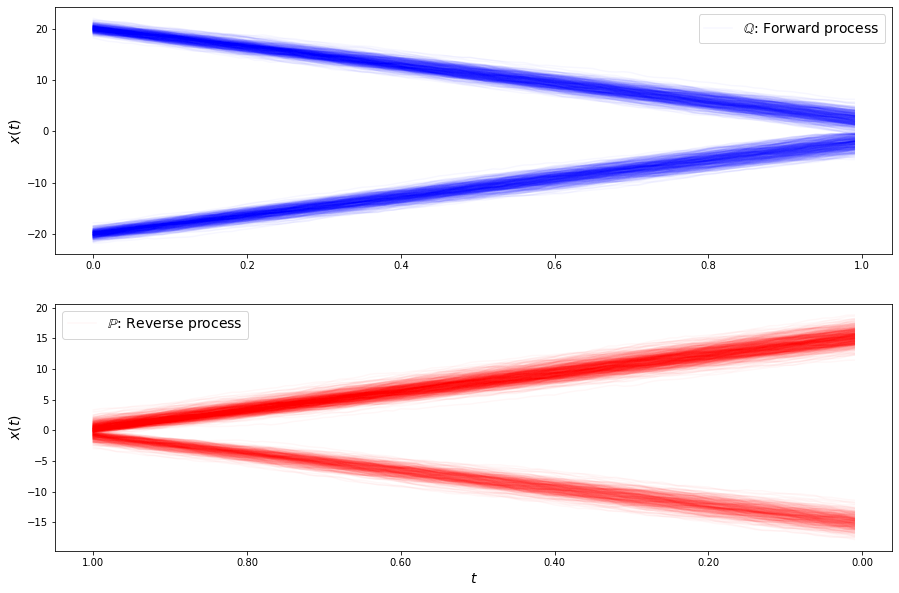

loss b 15.515715221478066
loss b 15.499481822921782
loss b 15.390713366278954
loss b 15.414832669858407
loss b 15.516758881834257
loss b 15.39489087329011
loss b 15.40161560972319
loss b 15.431607777507262
loss b 15.38001342680923
loss b 15.34479444992385
loss b 15.279405307934667
loss b 15.349899836989852
loss b 15.266745450747388
loss b 15.131277288678143
loss b 15.257166763397684
loss b 15.141965674764041
loss b 15.206425182799933
loss b 15.327170012885407
loss b 15.100259023614875
loss b 15.012198622895543
loss b 15.03503486012318
loss b 15.069212158065609
loss b 15.135959006048438
loss b 14.876082194617606
loss b 14.883728597920872
loss b 14.676408659380854
loss b 14.80804721619535
loss b 14.716574972469703
loss b 14.948475292859717
loss b 14.81290557460453
loss f 12.819512320104032
loss f 12.813453783494106
loss f 12.376490271930862
loss f 12.800435441795031
loss f 12.943322225320216
loss f 13.129147130460192
loss f 12.523970030940806
loss f 12.579989355268209
loss f 12.499375681

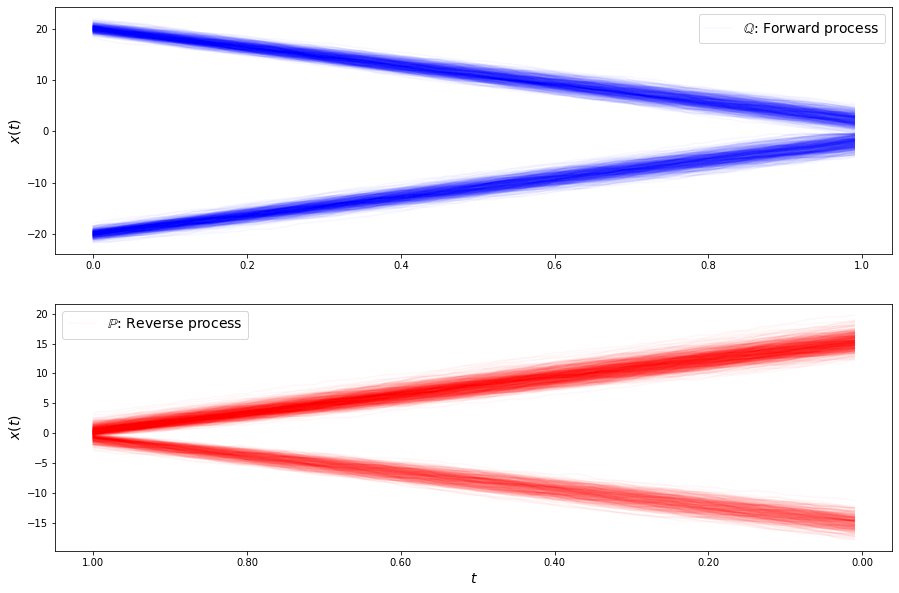

loss b 15.16053533012962
loss b 15.105059220909514
loss b 15.046249158140881
loss b 15.115317316785516
loss b 15.089378427081742
loss b 14.86390710932153
loss b 15.184792900241451
loss b 14.95415110285625
loss b 14.918227723140172
loss b 14.89080800867167
loss b 14.809447658738112
loss b 14.672246280895887
loss b 14.757413959775377
loss b 14.829222840260517
loss b 14.727372914273701
loss b 14.737111381034854
loss b 14.65799056723475
loss b 14.84139151743466
loss b 14.73169794081116
loss b 14.691721013831712
loss b 14.481491414358793
loss b 14.548138152403828
loss b 14.506454904885032
loss b 14.572407242867227
loss b 14.416638286404677
loss b 14.448912807686916
loss b 14.43700926922223
loss b 14.323308350998536
loss b 14.5341597724444
loss b 14.360158057964524
loss f 12.421814455282451
loss f 12.47910727352335
loss f 12.083271659767806
loss f 11.774153886216473
loss f 12.6649628191208
loss f 12.04236549506424
loss f 12.193981602509972
loss f 11.915745100857233
loss f 11.973975880102886


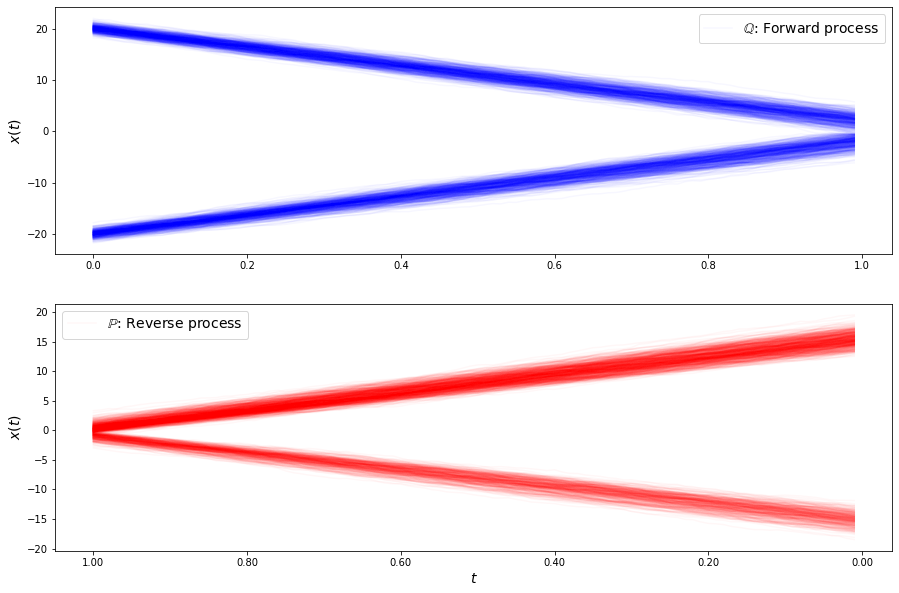

loss b 14.571957846665397
loss b 14.453284990862413
loss b 14.797280761562247
loss b 14.533740556731251
loss b 14.535576266536252
loss b 14.636724382075968
loss b 14.584987807635459
loss b 14.432441662059054
loss b 14.276342675309209
loss b 14.423848842530909
loss b 14.334302149035338
loss b 14.415948923543702
loss b 14.360761705283714
loss b 14.24409154922878
loss b 14.424560552523959
loss b 14.277125948428766
loss b 14.111270694796765
loss b 14.109423585548942
loss b 14.179239678598938
loss b 14.160164368313563
loss b 14.212538373631315
loss b 14.003303147524194
loss b 14.112193084964005
loss b 14.185677727454603
loss b 14.001171595104669
loss b 13.872116796131102
loss b 13.939948535278997
loss b 14.050432905453645
loss b 14.016106694083026
loss b 13.73823673234708
loss f 11.777427001919524
loss f 11.721679290286184
loss f 11.93623620468806
loss f 11.278631198364467
loss f 11.655591894182667
loss f 11.79358649273573
loss f 11.487976422722545
loss f 11.175754152905595
loss f 11.668851

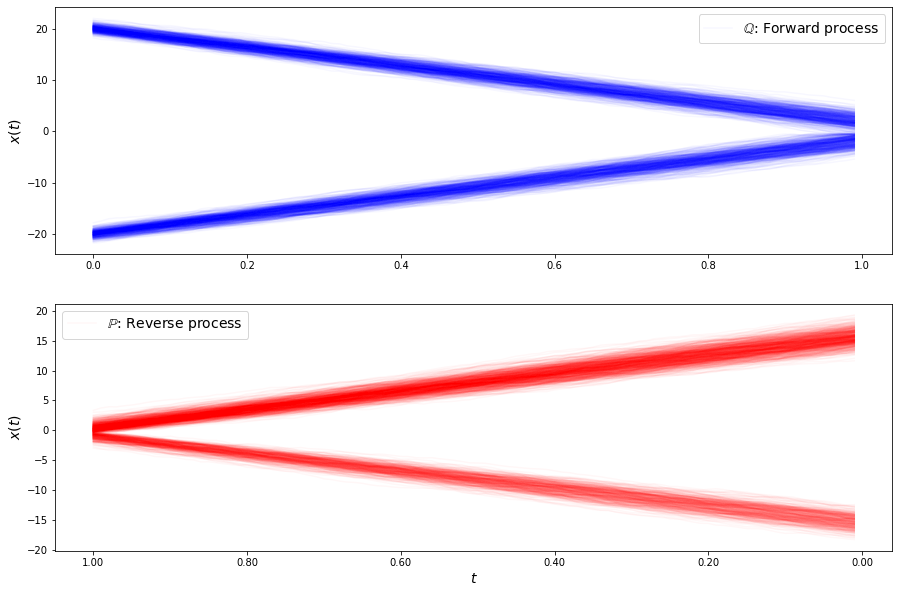

loss b 14.199496683626219
loss b 14.219097323035276
loss b 14.168538856541101
loss b 14.291684196127703
loss b 14.154694324840358
loss b 14.156043138703017
loss b 14.357147824359341
loss b 14.028453013079812
loss b 14.154478436982744
loss b 13.902325646936209
loss b 14.086107589440411
loss b 13.868159472658297
loss b 13.734355699450255
loss b 13.883993440267952
loss b 13.836822521017606
loss b 13.796835529055326
loss b 13.864732276746967
loss b 13.773930245446087
loss b 13.676966138272793
loss b 13.638478294843907
loss b 13.723324366112962
loss b 13.793231559047232
loss b 13.58713441658223
loss b 13.697083740302123
loss b 13.75508928375467
loss b 13.458011461035717
loss b 13.514579609419382
loss b 13.541334862292752
loss b 13.547771142791333
loss b 13.42098503657024
loss f 11.093327617883897
loss f 10.9157687479599
loss f 11.157999154943008
loss f 10.837070956328024
loss f 11.084946563817272
loss f 11.003035248434786
loss f 11.174505538518234
loss f 11.231133522648243
loss f 11.1958298

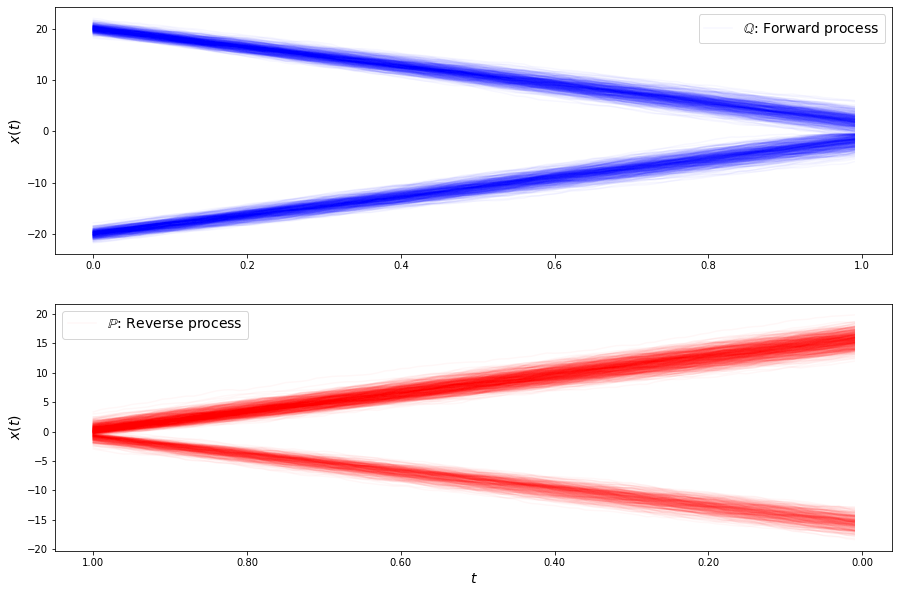

loss b 13.677890200866853
loss b 13.80012642755404
loss b 13.663288348144697
loss b 13.61986717625208
loss b 13.554170171182484
loss b 13.473149116841592
loss b 13.688245134477809
loss b 13.618708464556367
loss b 13.659279526578581
loss b 13.522198428931368
loss b 13.512713413084782
loss b 13.592692460616467
loss b 13.504435962058112
loss b 13.459214028064716
loss b 13.28335500789747
loss b 13.480116610002307
loss b 13.442288573099633
loss b 13.31844883918421
loss b 13.146510680045305
loss b 13.295911242938262
loss b 13.276318115340834
loss b 13.222670167876185
loss b 13.24985651209162
loss b 13.176303384852973
loss b 13.150858207176126
loss b 13.204220385287828
loss b 13.123065895573973
loss b 13.07320174295338
loss b 13.134200512066
loss b 13.112913203635866
loss f 10.645245233364244
loss f 10.590989297177208
loss f 10.76856236280976
loss f 10.750228621892226
loss f 10.410955621809034
loss f 10.421611938046544
loss f 10.654789533522848
loss f 10.844582552217329
loss f 10.481845099030

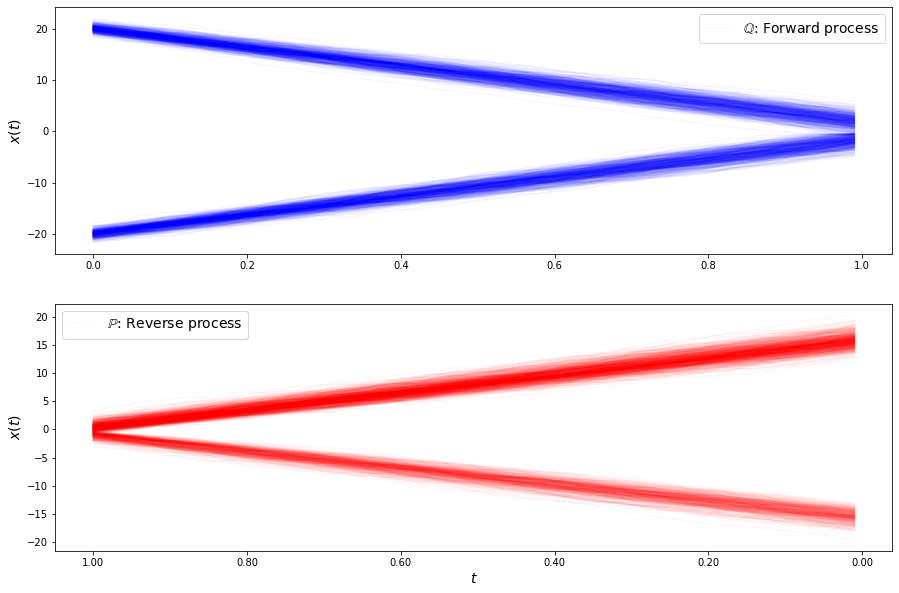

loss b 13.325133157142998
loss b 13.109073024951163
loss b 13.335865808602941
loss b 13.394077705746456
loss b 13.306936107900006
loss b 13.336636882865355
loss b 13.063892619161688
loss b 12.992393577932184
loss b 13.000581323777444
loss b 13.162074733906849
loss b 13.159586258559266
loss b 12.959211977077857
loss b 12.96480834071608
loss b 12.787265795724064
loss b 13.136732198092663
loss b 12.973231057086805
loss b 12.936866586245019
loss b 12.902338357769139
loss b 13.05549874916595
loss b 13.146736133468735
loss b 13.00579648978139
loss b 12.832478720874699
loss b 12.75854676211914
loss b 12.708709568570129
loss b 12.807045427886168
loss b 12.760483709284008
loss b 12.925139304309353
loss b 12.884683265727217
loss b 12.684613264549602
loss b 12.574734687263653
loss f 10.5305632015758
loss f 9.990943006463608
loss f 10.531894100193684
loss f 10.107600116979327
loss f 9.782782398348242
loss f 10.238808718224671
loss f 10.345574438167365
loss f 10.217749755690118
loss f 10.0762337603

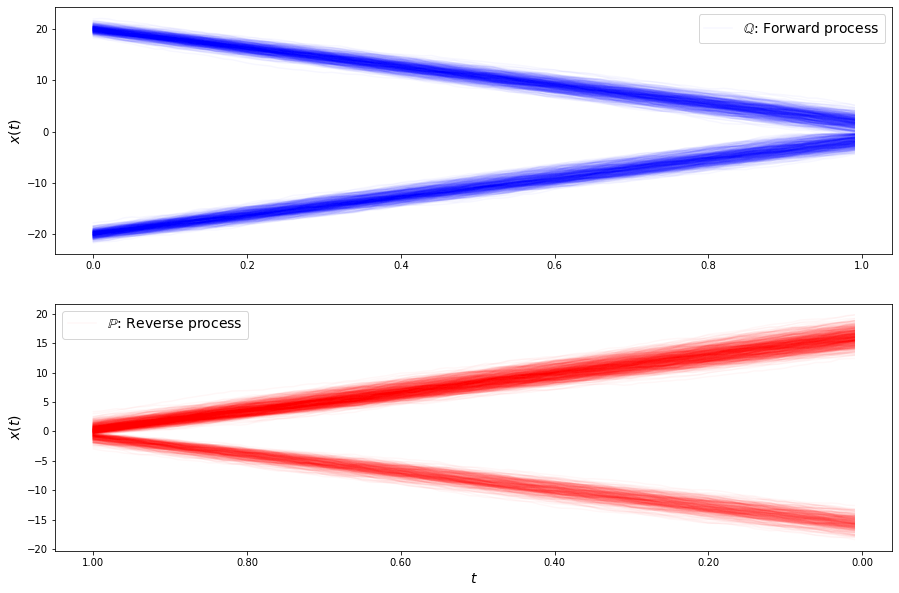

loss b 13.055834537111249
loss b 12.84216943510981
loss b 12.834601556645787
loss b 12.905514871037019
loss b 12.776050536958198
loss b 12.764783347007253
loss b 12.793002319042666
loss b 12.776785099919218
loss b 12.813272937862557
loss b 12.751427511311771
loss b 12.712562725259668
loss b 12.62263198266313
loss b 12.584921178192728
loss b 12.563228023603505
loss b 12.592855919907793
loss b 12.602912062915822
loss b 12.668399462354694
loss b 12.632368118736542
loss b 12.522814234052978
loss b 12.48408240362762
loss b 12.444030571380077
loss b 12.530117473539875
loss b 12.437572188740676
loss b 12.43036070946916
loss b 12.21646114498669
loss b 12.457153794742089
loss b 12.395689087002511
loss b 12.413366515050175
loss b 12.440900971366261
loss b 12.297707049867174
loss f 10.08836080406595
loss f 9.64737204476885
loss f 9.705806696770786
loss f 9.846455163222288
loss f 9.70398708101533
loss f 10.175340157543639
loss f 9.985301336207876
loss f 9.931435833374577
loss f 9.815534119168701
l

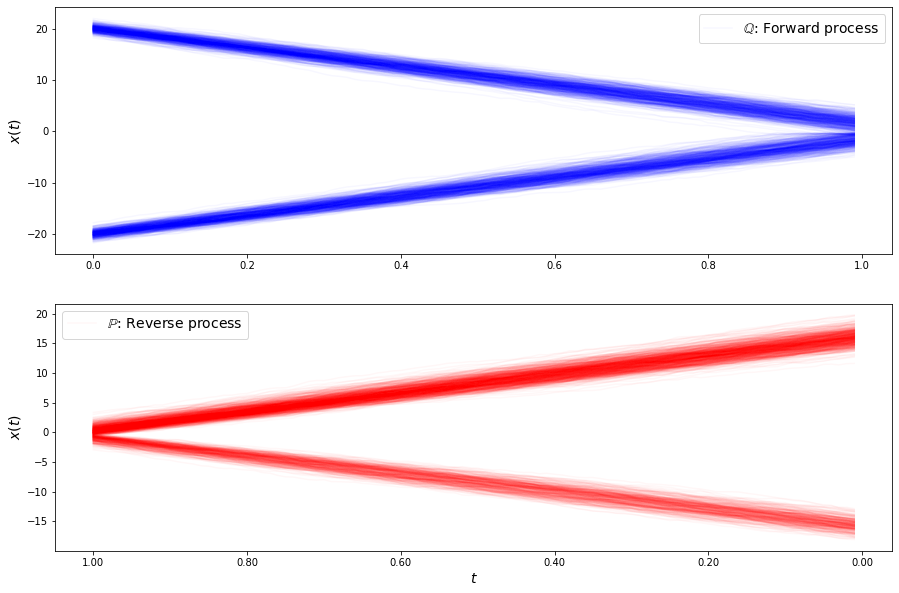

loss b 12.543239303924192
loss b 12.472729506591508
loss b 12.388541043198334
loss b 12.490810816612802
loss b 12.364440954965431
loss b 12.477160334723616
loss b 12.311933520211426
loss b 12.249715754641148
loss b 12.337476714314418
loss b 12.202856661488154
loss b 12.210873251715817
loss b 12.3133362498663
loss b 12.097261520889388
loss b 12.189961050070293
loss b 12.120777442303723
loss b 12.142981845948674
loss b 12.218532343326858
loss b 12.223955032373164
loss b 12.281704348346748
loss b 12.294268283638623
loss b 12.100052452266628
loss b 11.99441228258675
loss b 11.982025645382919
loss b 12.054731852733457
loss b 12.222385794825957
loss b 11.936234874065187
loss b 11.909398033270607
loss b 12.132838594552885
loss b 11.897107365948933
loss b 11.903414802155018
loss f 9.64681944897704
loss f 9.769671739739218
loss f 9.677649850543395
loss f 9.245406676961586
loss f 9.413901472725069
loss f 9.842127504746003
loss f 9.500139005473633
loss f 9.843871167549658
loss f 9.73350992693577


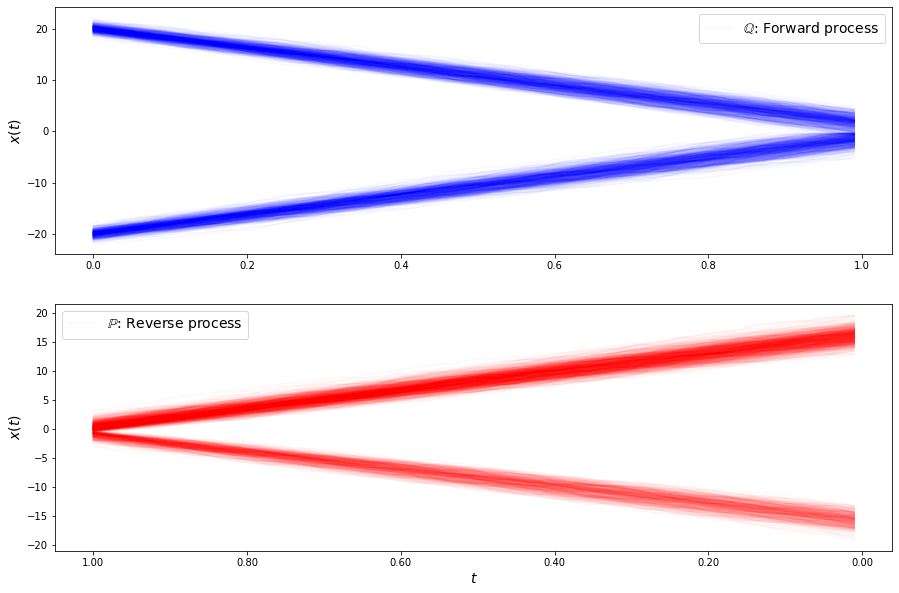

loss b 11.965072755550702
loss b 12.028124568937866
loss b 11.99402179282972
loss b 12.099470103924643
loss b 12.177726560117293
loss b 12.017046660558217
loss b 12.011970886792593
loss b 11.901643610433831
loss b 12.206848555937828
loss b 11.955137231376229
loss b 11.925922808853889
loss b 11.710186319509658
loss b 11.887184184385294
loss b 11.928220461705774
loss b 11.905496742550694
loss b 11.817608810340255
loss b 11.72207154449876
loss b 11.901591337107845
loss b 11.868769269937122
loss b 11.898800729344496
loss b 11.793135486781535
loss b 11.777789471420961
loss b 11.811243410548126
loss b 11.781078529328322
loss b 11.477301979191543
loss b 11.788728401814684
loss b 11.72189286223776
loss b 11.513745153333343
loss b 11.769144580553878
loss b 11.638175452826765
loss f 9.330294359325524
loss f 9.303275225003752
loss f 9.263295020461154
loss f 9.227693550445506
loss f 9.198963567984206
loss f 9.224377006346046
loss f 9.459513839026567
loss f 9.132941358865946
loss f 9.34257616435174

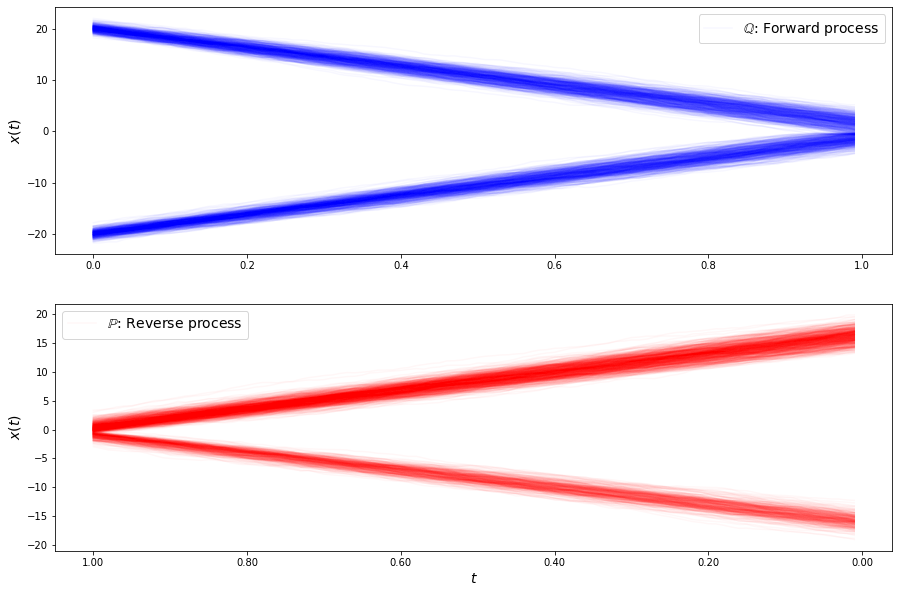

loss b 11.687805858576809
loss b 11.660253078105416
loss b 11.67129127774275
loss b 11.667596130455928
loss b 11.720489481971063
loss b 11.662626623776388
loss b 11.743337737340104
loss b 11.605290189634319
loss b 11.707058159524145
loss b 11.67742300720909
loss b 11.702745524248897
loss b 11.681755785031116
loss b 11.595187546610742
loss b 11.44533994809605
loss b 11.523728565535654
loss b 11.558055229420694
loss b 11.560153326744596
loss b 11.48292542745825
loss b 11.499919319584935
loss b 11.276787101238567
loss b 11.367367362208876
loss b 11.443660095483908
loss b 11.320499671321802
loss b 11.410367198896411
loss b 11.320579596546734
loss b 11.400798770335248
loss b 11.361919763866776
loss b 11.242891486999266
loss b 11.162015912908227
loss b 11.30498803964383
loss f 9.055394883233166
loss f 9.283554358806926
loss f 9.197003517767103
loss f 8.807544518515366
loss f 8.947638578428588
loss f 9.093809217311453
loss f 9.119943555381056
loss f 8.7983990291759
loss f 8.877913959105987
lo

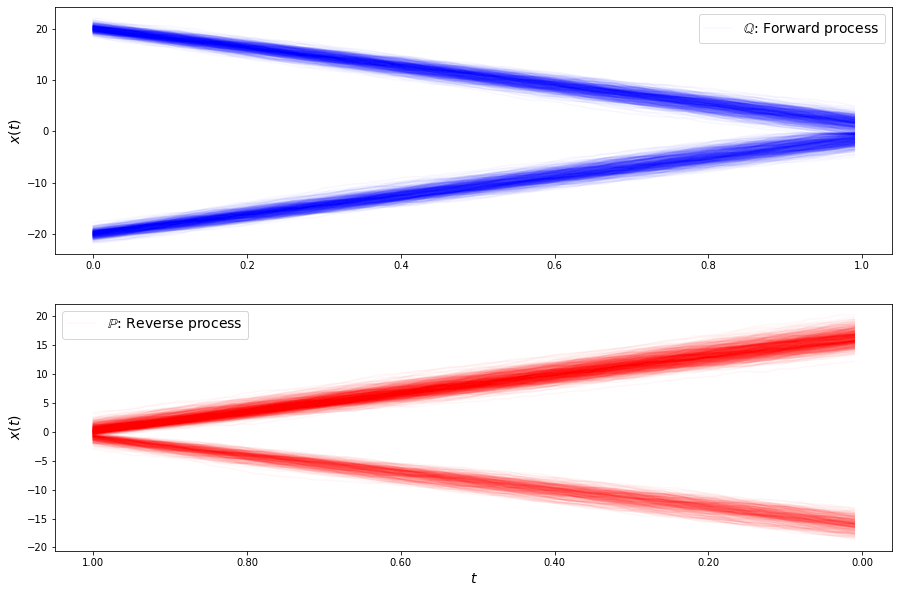

loss b 11.661850492488183
loss b 11.47940159430863
loss b 11.230324847571632
loss b 11.345658755409838
loss b 11.4571145962986
loss b 11.395489308324143
loss b 11.426659976294392
loss b 11.327900348908667
loss b 11.230077993229354
loss b 11.345748354839545
loss b 11.276053805620286
loss b 11.219414846388844
loss b 11.382519521552732
loss b 11.156324773691539
loss b 11.152427079838892
loss b 11.179349334909775
loss b 11.240330885249856
loss b 11.195205071733
loss b 11.250849183744876
loss b 11.045847779645761
loss b 11.167563202914389
loss b 11.271649191526587
loss b 11.106229665201658
loss b 11.406904414807114
loss b 10.911649005881545
loss b 11.039670686783898
loss b 11.167497976877167
loss b 11.050296587433637
loss b 10.877577347774945
loss b 10.833791509902978
loss f 8.582047129680838
loss f 8.784605189109952
loss f 8.839083400803455
loss f 8.59178669073336
loss f 8.555418970251818
loss f 8.728137558586875
loss f 8.711944208322507
loss f 8.728604951024558
loss f 8.704778616527804
lo

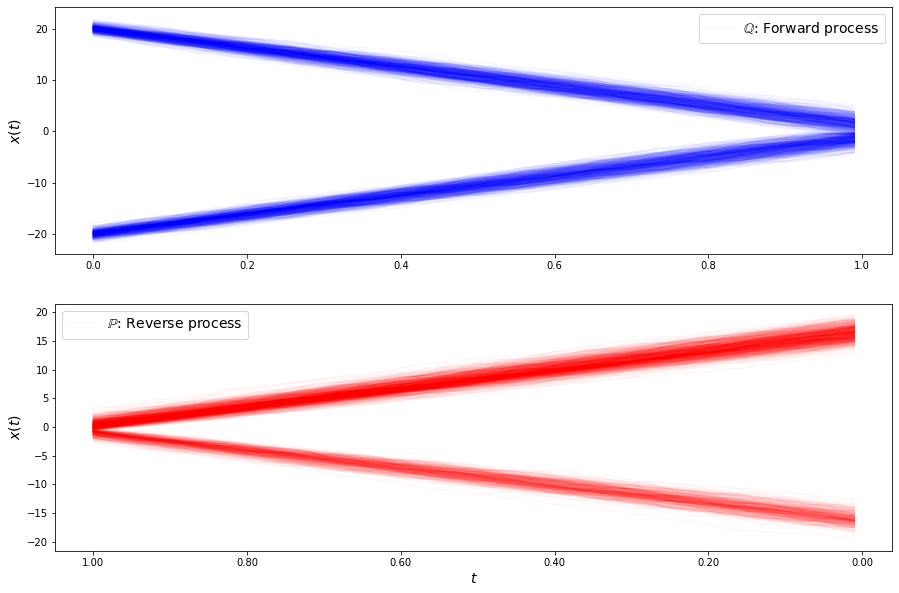

loss b 11.095376157028758
loss b 11.067293398945075
loss b 11.093254786184701
loss b 11.128440423909188
loss b 11.113577152177891
loss b 11.08953632361576
loss b 11.05639661244465
loss b 11.010612246738201
loss b 10.993549292014585
loss b 10.87698193748797
loss b 11.00349350331901
loss b 11.006307952936394
loss b 10.894308651316877
loss b 10.961813227181942
loss b 11.0335144072994
loss b 10.874330269218206
loss b 10.855293391516462
loss b 10.683248307337816
loss b 10.885192476653486
loss b 10.884456698520504
loss b 10.804698150599899
loss b 10.836508384406656
loss b 10.8254515573956
loss b 10.705333898148737
loss b 10.755245973598985
loss b 10.75124491417741
loss b 10.830307994667258
loss b 10.561405299511746
loss b 10.668333728689559
loss b 10.679059071873112
loss f 8.548972864699637
loss f 8.530818833238666
loss f 8.348809660707039
loss f 8.506560531403954
loss f 8.39033137779119
loss f 8.380773210422275
loss f 8.603558359747682
loss f 8.59366731681772
loss f 8.641714709947951
loss f

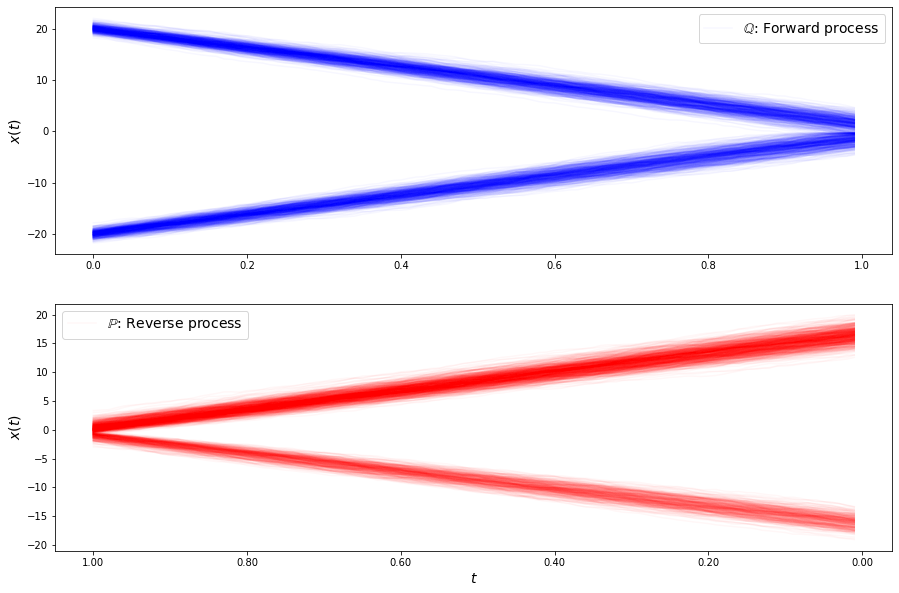

loss b 10.768238534313959
loss b 10.81899858418847
loss b 10.822689288356091
loss b 10.753187888395507
loss b 10.697157119618655
loss b 10.889387581200165
loss b 10.763410452382969
loss b 10.726730945015863
loss b 10.753783331492079
loss b 10.656074275543999
loss b 10.668305535981714
loss b 10.51255359223487
loss b 10.642968136513408
loss b 10.541963797172043
loss b 10.699927081345093
loss b 10.560891013804921
loss b 10.851227812396738
loss b 10.555053769226355
loss b 10.651548621782052
loss b 10.494706517536342
loss b 10.513806094644556
loss b 10.438544372405827
loss b 10.538820853293057
loss b 10.431978511529737
loss b 10.49070166813159
loss b 10.49659207051839
loss b 10.485895077057597
loss b 10.42425381040306
loss b 10.374954923998741
loss b 10.54196745721106
loss f 8.157791524883793
loss f 8.276893536150666
loss f 8.157391056017335
loss f 8.216047331190154
loss f 8.58773915492225
loss f 8.389219303204545
loss f 8.251109828113217
loss f 8.543941094007408
loss f 8.291917087101424
lo

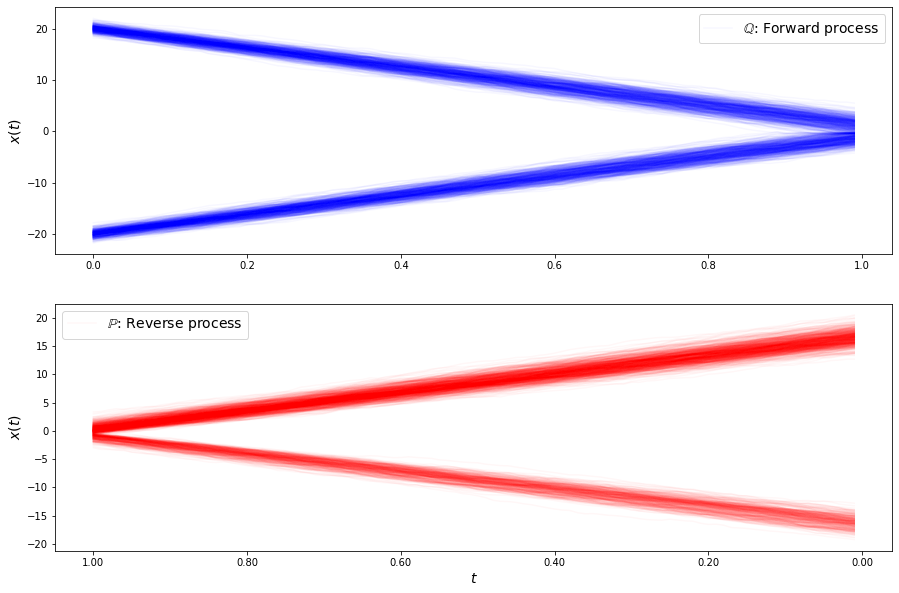

loss b 10.518017263428806
loss b 10.632185983847405
loss b 10.398173594931693
loss b 10.549523852847319
loss b 10.45914941462174
loss b 10.453052829214075
loss b 10.470138522671535
loss b 10.372021677494509
loss b 10.454384755116589
loss b 10.355949700937808
loss b 10.470789322863439
loss b 10.552966298972816
loss b 10.27779061486264
loss b 10.436105138224505
loss b 10.454481766265728
loss b 10.362661985926554
loss b 10.341936101814495
loss b 10.179726424708775
loss b 10.29010204223324
loss b 10.208977578212238
loss b 10.259512607051834
loss b 10.119617555568936
loss b 10.187699888754524
loss b 10.138790812796806
loss b 10.215772096218332
loss b 10.158812667351825
loss b 10.2191558217041
loss b 10.091420103122774
loss b 10.07190073972586
loss b 10.180970046366346
loss f 8.063596583213641
loss f 8.242874975157076
loss f 8.154926785623141
loss f 8.070738636654085
loss f 7.843046905567576
loss f 8.144929035069524
loss f 8.218529566948414
loss f 8.158435567132624
loss f 8.09382031717587
lo

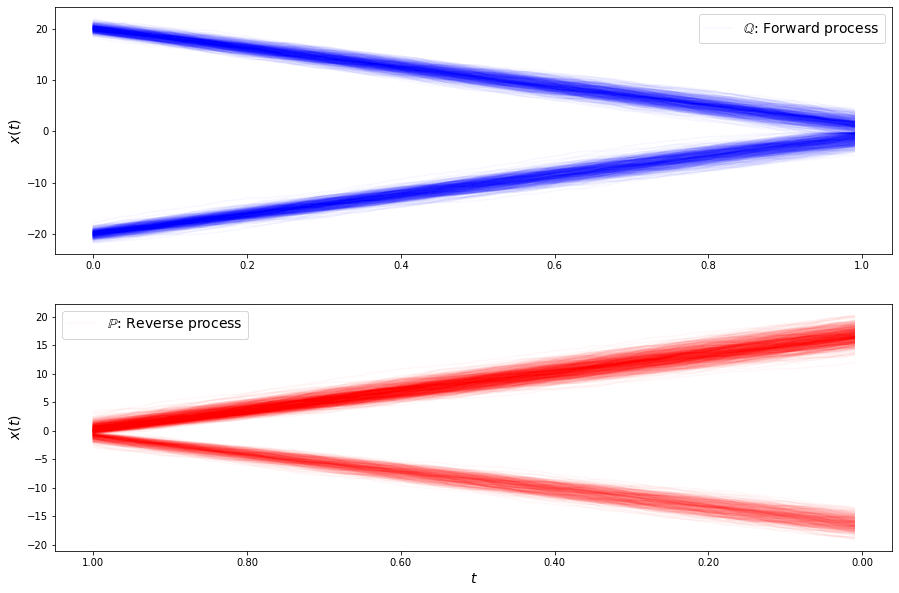

loss b 10.304793217118057
loss b 10.272032218146165
loss b 10.197810966717581
loss b 10.256434861098633
loss b 10.301242561405735
loss b 10.395667219777248
loss b 10.11481387961561
loss b 10.271533829006362
loss b 10.2289853867339
loss b 10.1544007779455
loss b 10.119239607862314
loss b 10.19542003419337
loss b 10.10326595317188
loss b 9.98972511178492
loss b 10.056648878846099
loss b 10.088172245260093
loss b 10.10763134410112
loss b 10.098309554154838
loss b 10.104609155618952
loss b 10.115994769113028
loss b 10.003786716992035
loss b 10.011326882262095
loss b 9.995744544044292
loss b 10.07966653116188
loss b 9.945864554646805
loss b 9.919414334125943
loss b 9.932859059257025
loss b 10.029674666628976
loss b 9.983859809381189
loss b 9.877875043063142
loss f 7.671693434498504
loss f 8.095182141805683
loss f 7.96588607904126
loss f 8.063200431840967
loss f 8.103259280305508
loss f 7.864048323788164
loss f 8.121796006747232
loss f 7.84465281406758
loss f 8.28198471925659
loss f 7.842623

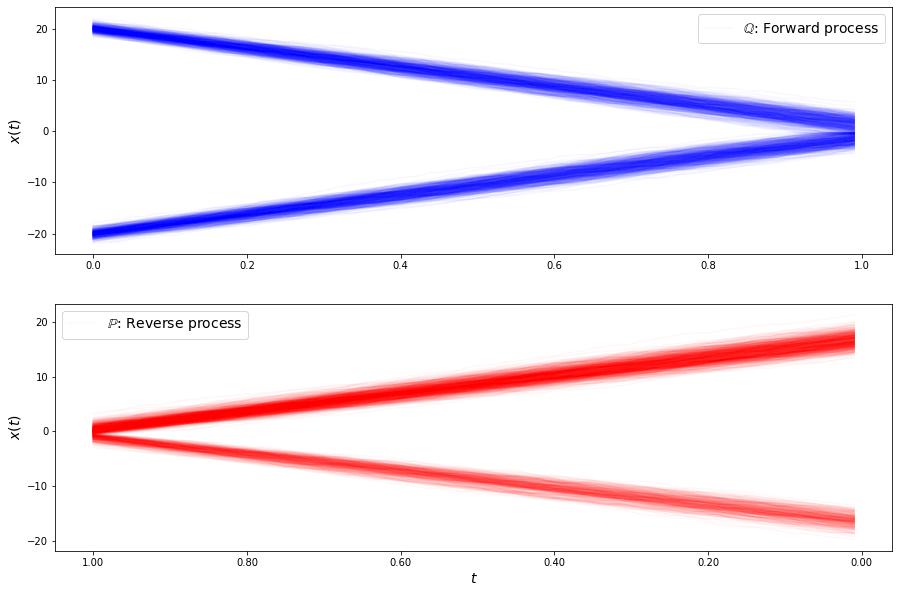

loss b 10.042892729094348
loss b 9.918078519751612
loss b 10.007150613469062
loss b 9.778455475017502
loss b 9.839151955989022
loss b 9.902108912004056
loss b 9.99628060231405
loss b 9.840256998083554
loss b 9.99624017193225
loss b 9.817979979826122
loss b 9.924850095142393
loss b 9.807747877852343
loss b 10.010182344411987
loss b 9.916721324602008
loss b 9.858915004116328
loss b 9.786323601326828
loss b 9.746363372863707
loss b 9.752266083984393
loss b 9.758177170246976
loss b 9.69304003139493
loss b 9.684967732573906
loss b 9.596099540360658
loss b 9.682978107820473
loss b 9.742311027244487
loss b 9.595326032652364
loss b 9.676227363766417
loss b 9.659410990008965
loss b 9.712689962001894
loss b 9.758059610347917
loss b 9.594634670415314
loss f 7.618936139326567
loss f 7.8527314888936255
loss f 7.890608155124771
loss f 7.976140919677516
loss f 7.854677293584262
loss f 7.570127489700397
loss f 7.948965724190927
loss f 7.532539855003959
loss f 7.995290272094314
loss f 7.621360822109173

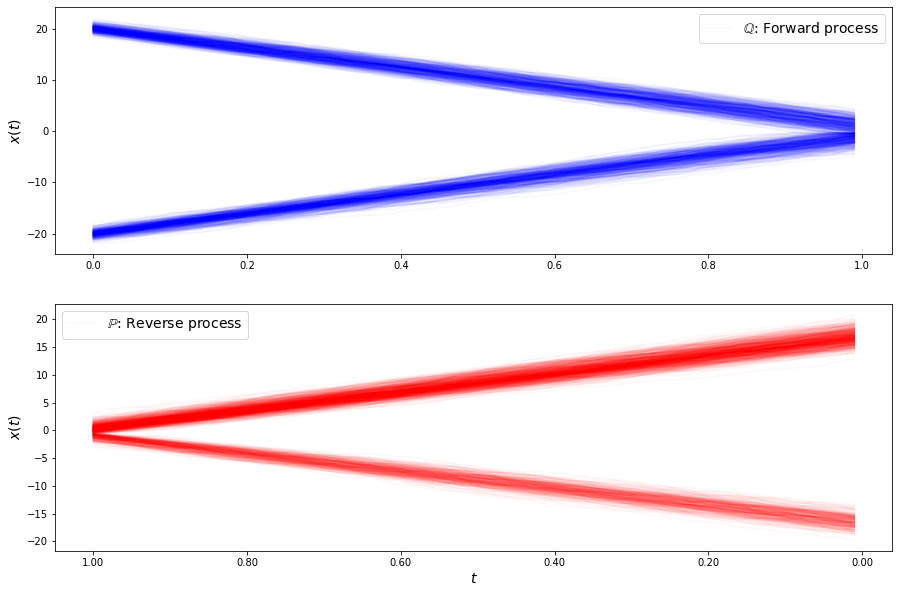

loss b 9.752750755276715
loss b 9.72032326295126
loss b 9.530143467836833
loss b 9.561961731785871
loss b 9.605433701827701
loss b 9.474648266163973
loss b 9.684138405131604
loss b 9.609256149341599
loss b 9.758724517969256
loss b 9.507196574988908
loss b 9.565508468779049
loss b 9.572432671679557
loss b 9.66107208650271
loss b 9.476524501758762
loss b 9.564001950838868
loss b 9.439123231882471
loss b 9.651269245127692
loss b 9.529474260132828
loss b 9.658621582496634
loss b 9.488093774823248
loss b 9.473688582216294
loss b 9.439955023972205
loss b 9.621569031643471
loss b 9.441929179983479
loss b 9.456497450938299
loss b 9.44832643800971
loss b 9.434750974173912
loss b 9.317740861264102
loss b 9.376285662456793
loss b 9.309937694450687
loss f 7.501786744175175
loss f 7.443610831424653
loss f 7.642607778077395
loss f 7.516372585258033
loss f 7.514583983156931
loss f 7.601777844031017
loss f 7.717517109670863
loss f 7.401014507045956
loss f 7.594338651346448
loss f 7.5182967505847715
lo

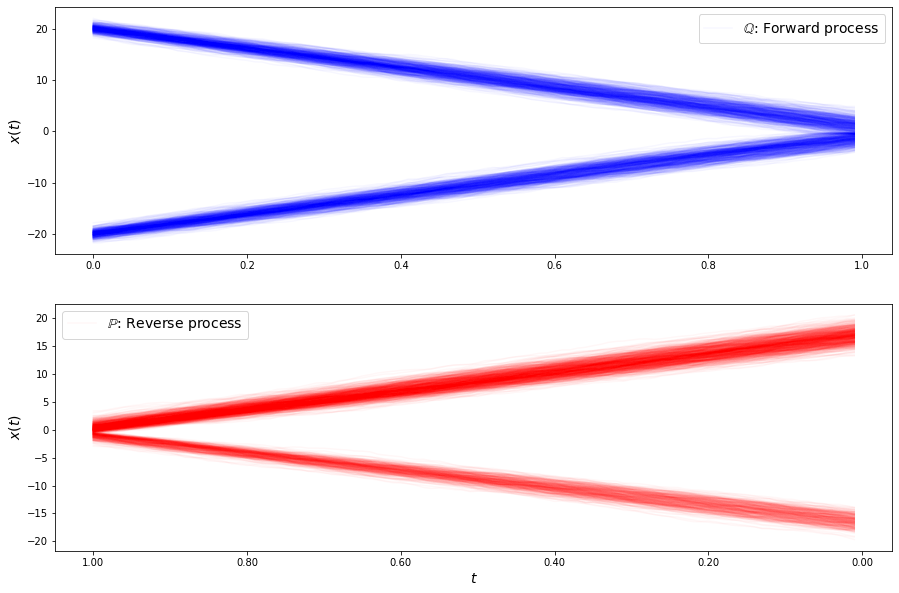

loss b 9.277254258763834
loss b 9.477859197593222
loss b 9.368793496513819
loss b 9.560328249052537
loss b 9.357821605591287
loss b 9.38974832532454
loss b 9.373439714105714
loss b 9.4218761596231
loss b 9.301821641491436
loss b 9.256829388270868
loss b 9.40208154917022
loss b 9.345068271579814
loss b 9.197531560284837
loss b 9.362932462075273
loss b 9.40237409922676
loss b 9.389180299627423
loss b 9.347360030605628
loss b 9.268226826729736
loss b 9.23463498949019
loss b 9.226570016892492
loss b 9.345243369630813
loss b 9.218700139400774
loss b 9.191566988876424
loss b 9.120505187959024
loss b 9.007820779938102
loss b 9.058649254619661
loss b 9.023773141804691
loss b 8.995167978735003
loss b 9.187499892198662
loss b 8.993088348339338
loss f 7.384334210528208
loss f 7.557055313315733
loss f 7.572810724793188
loss f 7.334894680832463
loss f 7.303981194728035
loss f 7.408783084511488
loss f 7.349063723747838
loss f 7.456574038115464
loss f 7.468123564897654
loss f 7.278826472866921
loss f

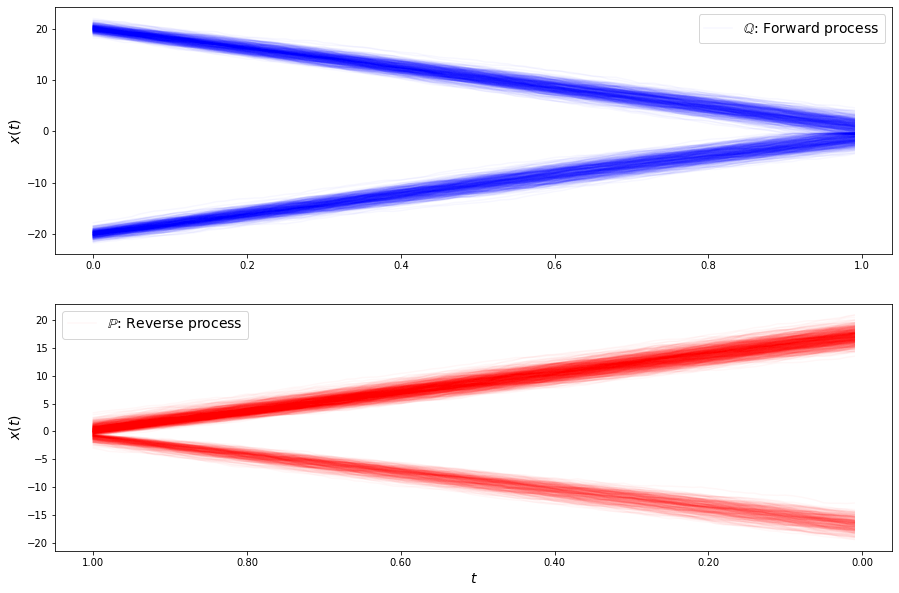

loss b 9.24583069224262
loss b 9.097892290799384
loss b 9.213974326520564
loss b 9.147527004362178
loss b 9.074686192735655
loss b 9.064509318138054
loss b 8.943091081080198
loss b 9.116528009292091
loss b 9.164319452555112
loss b 9.145405489321286
loss b 8.965923955584072
loss b 9.054647078161587
loss b 9.143141544829243
loss b 8.87814294019231
loss b 9.007492229739285
loss b 8.902262732675485
loss b 9.076471095569993
loss b 9.103444786374196
loss b 8.945958134015326
loss b 9.02968288304796
loss b 8.986665290894942
loss b 8.889998644731309
loss b 8.91760991422779
loss b 8.928688086305629
loss b 8.9369731403835
loss b 8.873720384443638
loss b 8.9434589913661
loss b 8.788469755233432
loss b 8.840386992734212
loss b 8.920450583494148
loss f 7.3584935746207325
loss f 7.209148540439762
loss f 7.364677382000073
loss f 7.019047579940909
loss f 7.0157083796971245
loss f 6.971905110098684
loss f 7.336757006062012
loss f 7.139058446904973
loss f 7.271313985718219
loss f 7.137595408319071
loss f

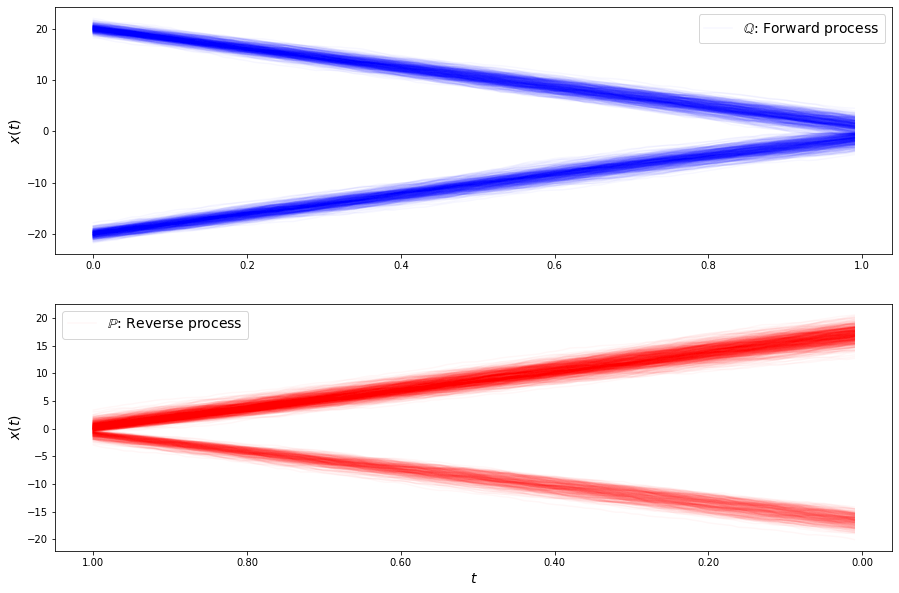

loss b 8.913962242423821
loss b 8.807258977388967
loss b 8.71668756699806
loss b 8.855083183944886
loss b 8.81336657304796
loss b 8.756759938622842
loss b 8.786383641122839
loss b 8.945805186138623
loss b 8.74284157907735
loss b 8.7984877927471
loss b 8.87980511447438
loss b 8.840707398616749
loss b 8.71662417967885
loss b 8.811744361141816
loss b 8.745589496145108
loss b 8.74261620865747
loss b 8.65675570217093
loss b 8.728274647160916
loss b 8.647524968913636
loss b 8.683334633983016
loss b 8.656743643632382
loss b 8.682039609669122
loss b 8.629777136234985
loss b 8.632522143358015
loss b 8.763098620829943
loss b 8.616453227114844
loss b 8.70225552484562
loss b 8.64636013640834
loss b 8.639169593631914
loss b 8.648123602031715
loss f 7.0586614211472805
loss f 7.190974714600313
loss f 6.939705442887403
loss f 6.921520839090644
loss f 6.983113376666826
loss f 6.930083078467557
loss f 6.975096155495605
loss f 6.843445508497708
loss f 7.152570266662563
loss f 7.098446793514969
loss f 7.1

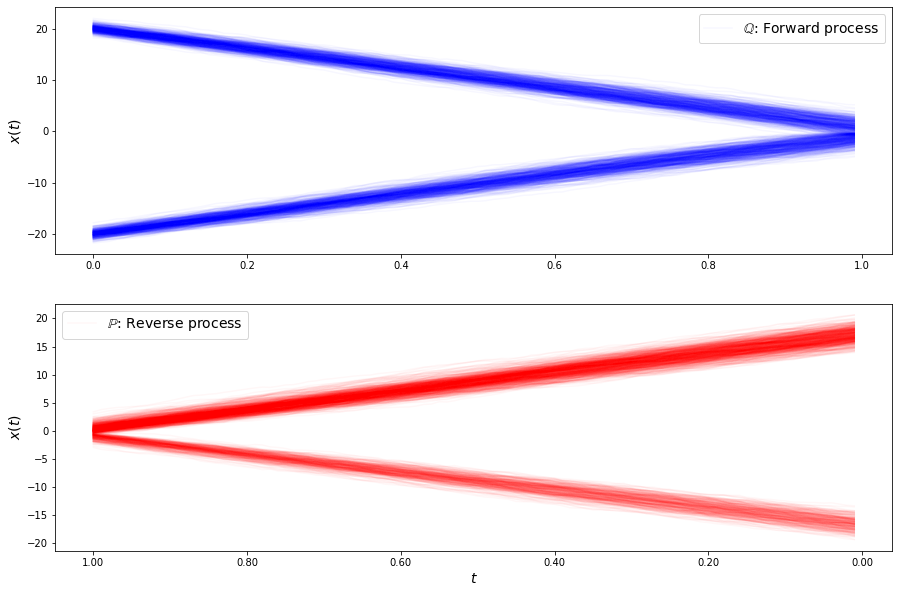

loss b 8.597748444147971
loss b 8.543529904682593
loss b 8.717883048100466
loss b 8.574648682422508
loss b 8.527984106523592
loss b 8.538896489894004
loss b 8.562723717778548
loss b 8.594372251575544
loss b 8.611531401901727
loss b 8.566085995485377
loss b 8.505802992723806
loss b 8.552187121785634
loss b 8.569894562170724
loss b 8.454680065512912
loss b 8.560717506680188
loss b 8.434625449222303
loss b 8.611737356920539
loss b 8.441142066384261
loss b 8.392188345511162
loss b 8.481760051733078
loss b 8.498118803007902
loss b 8.490430875479717
loss b 8.437255920518739
loss b 8.391710238131818
loss b 8.445043647424635
loss b 8.478987910651272
loss b 8.391616760705745
loss b 8.410173268320365
loss b 8.416201600941966
loss b 8.319700833704431
loss f 7.006377212462335
loss f 6.908734871587501
loss f 6.60063458036468
loss f 7.014764495289283
loss f 7.021840201354446
loss f 7.070721843635838
loss f 6.984056366197576
loss f 6.909832593719437
loss f 6.906698997352633
loss f 6.977442910022973
l

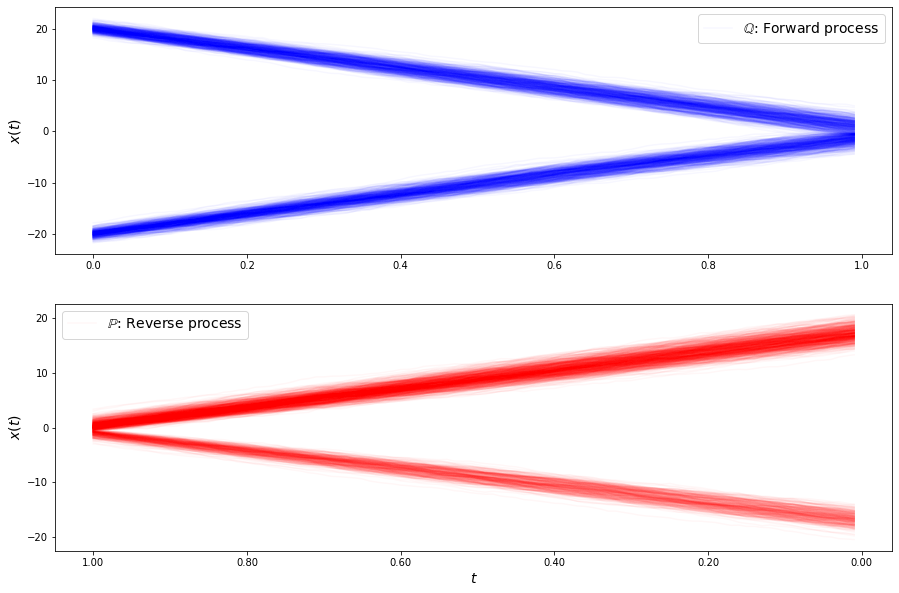

loss b 8.379489847509745
loss b 8.450283305605032
loss b 8.466867738093045
loss b 8.235278582452734
loss b 8.258893987485225
loss b 8.332262208699593
loss b 8.386825987272207
loss b 8.244006404681867
loss b 8.416117778714634
loss b 8.354971542214031
loss b 8.32761384716267
loss b 8.359596366170912
loss b 8.232090819114758
loss b 8.362915007197495
loss b 8.216322264604774
loss b 8.298419506573756
loss b 8.239639372212167
loss b 8.317196948381039
loss b 8.224946096125793
loss b 8.190507356257754
loss b 8.040707568693731
loss b 8.367720841037528
loss b 8.154401185382214
loss b 8.215373970402803
loss b 8.245592002242041
loss b 8.037200610758635
loss b 8.302338123514067
loss b 8.147142376525766
loss b 8.067149828710711
loss b 8.071354448378655
loss f 6.681727846895589
loss f 6.596140426264363
loss f 6.859231519398945
loss f 6.8114668800303955
loss f 6.831503808134589
loss f 6.873306514374647
loss f 6.927126395793388
loss f 6.907439701538138
loss f 6.859809828068221
loss f 6.861623672149536


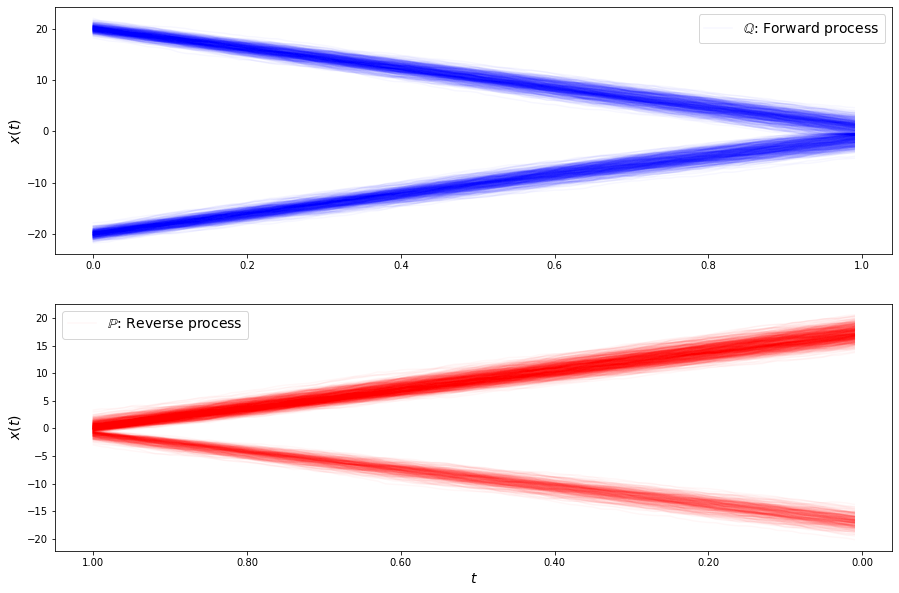

loss b 8.033487198324178
loss b 8.117785461506687
loss b 8.025241175954445
loss b 8.101851303544413
loss b 8.018096116927119
loss b 8.174448498948266
loss b 8.085392750924461
loss b 8.119427034859381
loss b 8.067281490360292
loss b 8.085129871056404
loss b 8.133460651949788
loss b 8.128340046029251
loss b 8.138887202051473
loss b 8.12509386358367
loss b 8.034725814682185
loss b 7.986225021509645
loss b 8.03151346422375
loss b 7.943997913452913
loss b 8.048279017900096
loss b 7.960610404871774
loss b 7.892962832738087
loss b 8.083198086157871
loss b 7.993610159929781
loss b 8.052106407805537
loss b 8.059807311766951
loss b 8.087196926173936
loss b 7.997358483868648
loss b 7.923489252573059
loss b 7.98084820091613
loss b 7.897718750715034
loss f 6.622454057656844
loss f 6.536128551110285
loss f 6.898155983351854
loss f 6.6267027416151265
loss f 6.461751887535335
loss f 6.605580134754065
loss f 6.606700348142609
loss f 6.71532759709755
loss f 6.692441840781166
loss f 6.663231855142786
los

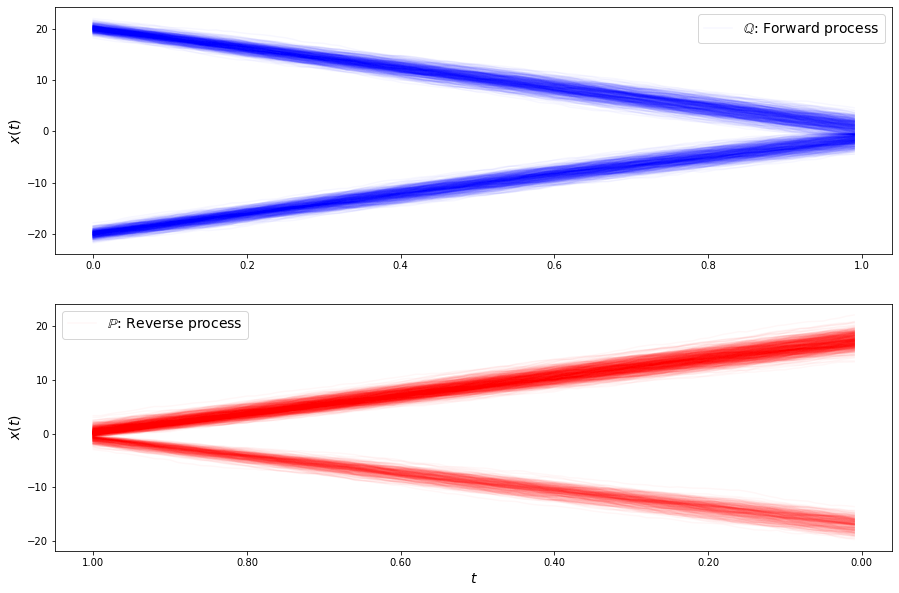

loss b 7.941946673113934
loss b 7.9368347991939485
loss b 8.048139541780074
loss b 7.913918273482447
loss b 7.874351093028289
loss b 7.854899516067649
loss b 7.92065621321524
loss b 7.8212827856717135
loss b 7.807029174791063
loss b 7.866306198126966
loss b 7.863085058293478
loss b 7.862373011583472
loss b 7.848827563664786
loss b 7.8352647250297744
loss b 7.663633626448297
loss b 7.804202823877503
loss b 7.802884818383169
loss b 7.8601430562660815
loss b 7.752724756307727
loss b 7.635653631591666
loss b 7.7922861488034325
loss b 7.776795167448487
loss b 7.698762368058642
loss b 7.706813207077394
loss b 7.791987126863972
loss b 7.699178435266337
loss b 7.749697693561712
loss b 7.7801693687232705
loss b 7.807137944624582
loss b 7.694576073510098
loss f 6.7343300577252325
loss f 6.467279884564954
loss f 6.632383283556194
loss f 6.7114894337784845
loss f 6.6766560084565825
loss f 6.564075702478905
loss f 6.410099430021021
loss f 6.551964905805265
loss f 6.616113026555326
loss f 6.57021013

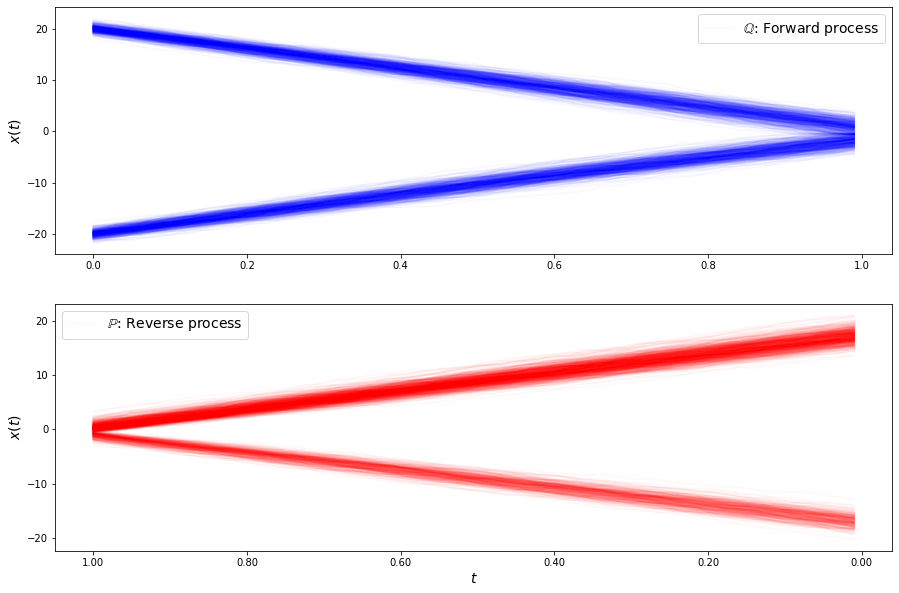

loss b 7.740725522887095
loss b 7.709749779848268
loss b 7.675631216397712
loss b 7.764245038844911
loss b 7.6896659205237485
loss b 7.644349207103324
loss b 7.6817800585561224
loss b 7.586512965724993
loss b 7.635128009043004
loss b 7.570824184003342
loss b 7.610941851982115
loss b 7.611946690453991
loss b 7.595388780104836
loss b 7.648976448249232
loss b 7.5136310498072225
loss b 7.6423771505039015
loss b 7.531896955727756
loss b 7.6169831527892295
loss b 7.5355163883218195
loss b 7.5603723646150325
loss b 7.525292091066935
loss b 7.540863773434356
loss b 7.529666378223059
loss b 7.54456677654836
loss b 7.540320936558008
loss b 7.4824774475971445
loss b 7.507073887445967
loss b 7.48654068084738
loss b 7.449451987217078
loss b 7.412488493559757
loss f 6.250578573465058
loss f 6.695632607552342
loss f 6.47252730892704
loss f 6.526295308782083
loss f 6.570899249061506
loss f 6.505414145798094
loss f 6.348553508364641
loss f 6.369118598866208
loss f 6.345266654765087
loss f 6.45726070913

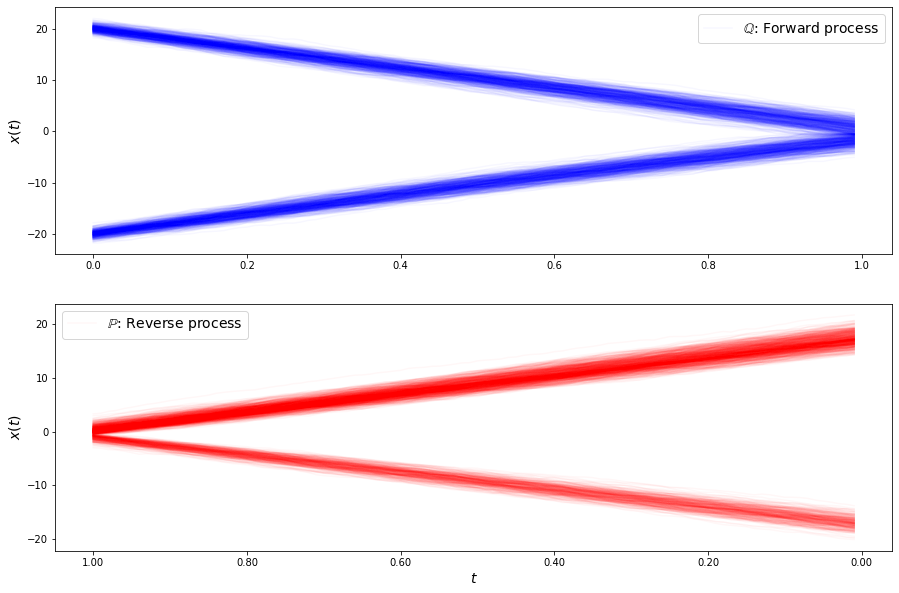

loss b 7.4581718717025005
loss b 7.355805129467072
loss b 7.426869037006172
loss b 7.327983260148024
loss b 7.443181571629094
loss b 7.297807152601572
loss b 7.299045557416758
loss b 7.503216634544415
loss b 7.320721780203145
loss b 7.250505606462267
loss b 7.42889366098181
loss b 7.3445926631018414
loss b 7.345382436138514
loss b 7.380307484386027
loss b 7.417354591241748
loss b 7.383185177152979
loss b 7.403385715775911
loss b 7.422471111234424
loss b 7.2983822197634955
loss b 7.352398216950712
loss b 7.360645630854539
loss b 7.304132440362276
loss b 7.325756356904649
loss b 7.413944215449268
loss b 7.350028666289074
loss b 7.302299477425786
loss b 7.319990878625194
loss b 7.269921692969029
loss b 7.283095405916366
loss b 7.304391029771511
loss f 6.533988776466736
loss f 6.563932773945225
loss f 6.354672018934492
loss f 6.440594177223929
loss f 6.3884651711259455
loss f 6.490867097103529
loss f 6.538628719707916
loss f 6.612331998783147
loss f 6.25447735171817
loss f 6.46093783985311

In [ ]:


torch.autograd.set_detect_anomaly(True)
c.fit(200, 30, burn_iterations=2, plot=True)

In [ ]:
plt.plot(c.loss_f[10:])
plt.show()
plt.plot(c.loss_b[10:])

In [17]:
bb = lambda X: -c.b_backward(X)

t, Xts = c.sde_solver(
    c.b_forward.forward, c.sigma,
    c.X_0, c.dt,  c.number_time_steps, 0.0,
    c.theta_f, False, True
)
t_, Xts_ = c.sde_solver(
    bb, c.sigma, 
    c.X_1, c.dt, c.number_time_steps, 0.0, 
    c.theta_b, False, False
)

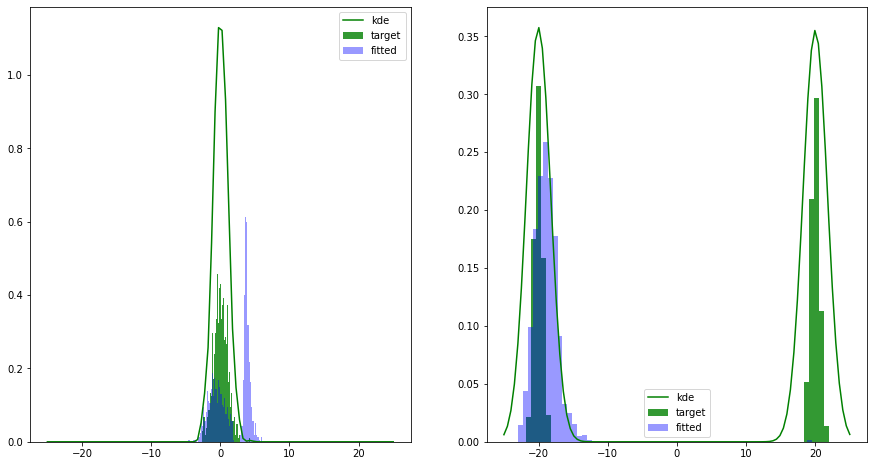

In [18]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
batch_terminal_empirical_f = next(c.data_stream(forward=True))
xx = torch.linspace(-25, 25).reshape(-1,1).cuda().double()

H = silvermans_rule(batch_terminal_empirical_f)
kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, H).detach().cpu().numpy())
axs[1].plot(xx.detach().cpu().numpy(), kd, label="kde", color="green")


bins = 60
axs[1].hist(( X1.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[1].hist(( Xts_[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[1].legend()




batch_terminal_empirical_b = next(c.data_stream(forward=False))
# xx = torch.linspace(-10, 10).reshape(-1,1).cuda().double()

Hb = silvermans_rule(batch_terminal_empirical_b)
kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, Hb).detach().cpu().numpy())
axs[0].plot(xx.detach().cpu().numpy(), kd, label="kde", color="green")


bins = 60
axs[0].hist(( X2.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[0].hist(( Xts[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[0].legend()